### Creations Graphs

      distancefrompoint    count
4558             4707.0        8
4559             5280.0       15
4560             8010.0        8
4561             9814.0        3
4562                NaN  6164673


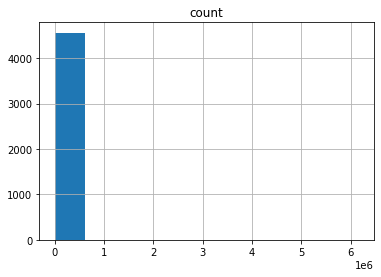

In [5]:
import psycopg2
import sshtunnel 
import pandas as pd
import psycopg2.extras


def get_stats_position(c):
        pd.set_option("display.max.columns", None)
        #"agency", "calendar","calendar_dates", "routes", "shapes"
        list_tables=["vehicleposition" ]
        #Get stats and graphs for each table
        for i in list_tables:
                c.execute(f"SELECT distancefrompoint, count(*) as count FROM {i} group by distancefrompoint;")
                data = c.fetchall()
                df=pd.DataFrame([i.copy() for i in data])
                print(df.tail())
                df.hist(column='count')



try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                c = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
                get_stats_position(c)
except Exception as e:
        print(e)



### Current Headways

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine
import sshtunnel 
import pandas as pd
import psycopg2.extras

In [4]:
# conneciton DBs
def connection():
    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                return conn
    except Exception as e:
            print(e)

In [5]:
#connect to database and get the trips and planned stops for a line
def get_data_from_database(lineId):
    
    #SQL statement
    sql = """Select distinct t.route_id,
    t.service_id,
    t.trip_id,
    t.trip_headsign,
    t.direction_id,
    st.arrival_time,
    st.departure_time,
    st.stop_id,
    r.route_type,
    c.start_date,
    c.end_date,
    c.monday,
    c.tuesday,
    c.wednesday,
    c.thursday,
    c.friday,
    c.saturday,
    c.sunday
    from trips t
    inner join stop_times st
    on t.trip_id = st.trip_id 
    inner join calendar c
    on t.service_id = c.service_id
    inner join routes r
    on t.trip_headsign = SUBSTRING(r.route_long_name from POSITION('-' IN r.route_long_name)+2
                        for char_length(r.route_long_name)-POSITION('-' IN r.route_long_name)+1)
    and r.route_id = t.route_id
    where c.end_date >= '2021-09-01'
    order by t.route_id,t.direction_id,c.start_date,t.service_id,st.stop_id,st.arrival_time"""
    
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

    


In [6]:
#insert results to database table assessment_methods
def insert_into_db(df_methods):
    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{db}'.format(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        db="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1" ))

                df_methods.to_sql('assessment_methods', engine, if_exists='append',index=False)
    except Exception as e:
            print(e)

In [7]:
#calculate the headway between the planned arrival of the vehicles
#df_stop = data frame with the schedule for one stop (sorted)
def calculate_headway(df_stop):
    d = []
    
    #loop through all entries in df_stop starting at index + 1
    for ind in df_stop.index + 1:
        
        #index in range (schauen ob man den noch eleminieren kann)
        if ind < len(df_stop.index):
            
            #in the following time1 is always the later time (entry with the higher index)
            # time1 get hour from arrival time to deal with times greater 23
            hour = df_stop['arrival_time'][ind][0:2]
            if int(hour) > 23:
                #translate times over 24 hours (24:35 --> 00:35)
                time_str = df_stop['arrival_time'][ind]
                new_time = time_str.replace(hour,str(0) + str(int(hour)-24))
                time1 = datetime.combine(date.min,datetime.strptime(new_time,'%H:%M:%S').time())
                hour = df_stop['arrival_time'][ind-1][0:2]
                
                #same check for time2
                # time2 get hour from arrival time to deal with times greater 23
                if int(hour)> 23:
                    time_str = df_stop['arrival_time'][ind-1]
                    new_time = time_str.replace(hour,str(0) + str(int(hour)-24))
                    time2 = datetime.combine(date.min,datetime.strptime(new_time,'%H:%M:%S').time())

                else:
                    #only time1 greater 23 take for time2 normal arrival time from dataframe
                    time2 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind-1],'%H:%M:%S').time())

            else:
                #arrival time from dataframe
                time1 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind],'%H:%M:%S').time())
                time2 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind-1],'%H:%M:%S').time())
            
            #calculate headway
            headway = time1 - time2
            
            #append to dictionary
            d.append(
                {
                    'Time': df_stop['arrival_time'][ind],
                    'headway': headway.seconds/60,
                }
            )
    
    #create dataframe from dictionary
    df_headways = pd.DataFrame(d)
    return df_headways

In [8]:
#Split data into groups with similar headways 
#returns a list of dataframe every dataframe in the list is a group with similar headway
def form_time_groups(df_headways):
    group_list=[]
    group=[]
    
    #start with the first headway entry
    group.append(
        {
            'Time': df_headways['Time'][0],
            'headway': df_headways['headway'][0],
        }
    )

    #loop through headway dataframe
    for ind in df_headways.index + 1:
        
        #schauen ob anders machen kann
        if ind < len(df_headways.index):
            
            #Calculate the difference of headway between 2 stop times
            headway1 = df_headways['headway'][ind]
            headway2 = df_headways['headway'][ind-1]
            diff = abs(headway1 - headway2)

            #if difference >=2 start a new group (gucken ob hier den Median nehmen kann)
            if diff >= 2:
                #Append current group to goup_list
                df_group = pd.DataFrame(group)
                group_list.append(df_group)
                #create new group
                group.clear()

            #append entry to group
            group.append(
                {
                    'Time': df_headways['Time'][ind],
                    'headway': df_headways['headway'][ind],
                }
            )

    #append last group (if not empty bedingung einbauen)
    df_group = pd.DataFrame(group)
    group_list.append(df_group)

    return group_list

In [9]:
#Create from the time groups the timespans that should be assesed by regularity and the ones that should be assesd by punctuality
def assign_method(group_list,first_time, lineId,direction_id,stopId, date_from, date_to, monday, tuesday, wednesday, thursday, friday, saturday, sunday, route_type):
    
    #first trip in the morning always assesed by punctuality
    timefrom = first_time
    timeto = first_time
    last_method = 'punctuality'

    result=[]
    reg_count=0
    for group in group_list:
        #median headway of the group
        median = group['headway'].median()

        #median <= 12 might be assesd by regularity
        if median <= 12:
            #reg_count = reg_count + 1

            #Regularity only makes sense when at least two vehicles in a row should be assesed by regularity
            if len(group.index) >= 3 or last_method=='regularity':
                method = 'regularity'
            else:
                method = 'punctuality'
        else:
            method = 'punctuality'

        #If last group assessed by the same method merge groups
        if last_method == method:
            timeto = group['Time'].iat[-1]
        else:
        #Add group to dictionary
            timeto = group['Time'].iat[0]
            result.append(
                {
                    'route_id': lineId,
                    'direction_id': direction_id,
                    'stopId': stopId,
                    'time_from': timefrom,
                    'time_to': timeto,
                    'date_from':date_from,
                    'date_to':date_to,
                    'monday': monday,
                    'tuesday': tuesday,
                    'wednesday': wednesday,
                    'thursday': thursday,
                    'friday': friday,
                    'saturday': saturday,
                    'sunday': sunday,
                    'method': last_method,
                    'route_type': route_type,
                    'median_headway':median
                }
            )

            timefrom = timeto
            timeto = group['Time'].iat[-1]

        last_method = method

    #Append result of last loop (check if empty)
    result.append(
            {
                'route_id': lineId,
                'direction_id': direction_id,
                'stopId': stopId,
                'time_from': timefrom,
                'time_to': timeto,
                'date_from':date_from,
                'date_to':date_to,
                'monday': monday,
                'tuesday': tuesday,
                'wednesday': wednesday,
                'thursday': thursday,
                'friday': friday,
                'saturday': saturday,
                'sunday': sunday,
                'method': last_method,
                'route_type': route_type,
                'median_headway':median
            }
    )

    #Create and return dataframe
    df_result = pd.DataFrame(result)
    return df_result

In [10]:

def get_oneexample_regularity():
    df_data_database =  get_data_from_database(25)
    routes = df_data_database['route_id'].unique()
    for route in routes: 
        route_id = route
        df_route = df_data_database[(df_data_database.route_id == route)]
        #directions
        directions = df_route['direction_id'].unique()
        for direction in directions: 

            #current direction
            direction_id = direction
            df_direction = df_route[(df_data_database.direction_id == direction)]

            service_ids = df_direction['service_id'].unique()

            for service_id in service_ids:

                df_service_id = df_direction[(df_direction.service_id == service_id)]

                if not df_service_id.empty:
                    #details about service id
                    monday = df_service_id['monday'].iat[0]
                    tuesday = df_service_id['tuesday'].iat[0]
                    wednesday = df_service_id['wednesday'].iat[0]
                    thursday = df_service_id['thursday'].iat[0]
                    friday = df_service_id['friday'].iat[0]
                    saturday = df_service_id['saturday'].iat[0]
                    sunday = df_service_id['sunday'].iat[0]
                    date_from = df_service_id['start_date'].iat[0]
                    date_to = df_service_id['end_date'].iat[0]
                    route_type = df_service_id['route_type'].iat[0]


                    df_data_all_stops = df_service_id[['trip_id','arrival_time','departure_time','stop_id']]
                    #get all stops for a line
                    stops = df_data_all_stops['stop_id'].unique()

                        #for every stop determine the schedule
                    for stop in stops:
                        df_stop = df_data_all_stops[(df_data_all_stops.stop_id == stop)]
                        df_stop = df_stop.sort_values(by=['arrival_time'])
                        df_stop = df_stop.reset_index()

                        df_headways = calculate_headway(df_stop)

                        if not df_headways.empty:
                            

                            #check if headways <12 exist (if not assesed by punctuality)
                            if df_headways[df_headways['headway'].apply(np.float32) <= 12].count()['headway'] > 0:
                                #split data into groups with similar headways
                                group_list = form_time_groups(df_headways)
                                time_of_first_vehicle = df_stop['arrival_time'].iat[0]
                                df_methods = assign_method(group_list, time_of_first_vehicle,route_id,direction_id,stop,date_from,date_to,monday,tuesday,wednesday,thursday,friday,saturday,sunday,route_type)
                                print(df_methods)
                                return [df_methods,df_headways,group_list,time_of_first_vehicle]
                            else:
                                result=[]
                                result.append(
                                        {
                                            'route_id': route_id,
                                            'direction_id': direction_id,
                                            'stopId': stop,
                                            'time_from': df_stop['arrival_time'].iat[0],
                                            'time_to': df_stop['arrival_time'].iat[-1],
                                            'date_from':date_from,
                                            'date_to':date_to,
                                            'monday': monday,
                                            'tuesday': tuesday,
                                            'wednesday': wednesday,
                                            'thursday': thursday,
                                            'friday': friday,
                                            'saturday': saturday,
                                            'sunday': sunday,
                                            'method': 'punctuality',
                                            'route_type': route_type,
                                            'median_headway':-1
                                        }
                                    )

                                df_methods = pd.DataFrame(result)
                            
                

In [11]:
example=get_oneexample_regularity()

   route_id  direction_id stopId time_from   time_to   date_from     date_to  \
0         1             0   8012  05:34:48  06:13:37  2021-09-01  2021-09-17   
1         1             0   8012  06:13:37  23:28:01  2021-09-01  2021-09-17   
2         1             0   8012  23:28:01  24:27:01  2021-09-01  2021-09-17   

   monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0       1        1          1         1       1         0       0   
1       1        1          1         1       1         0       0   
2       1        1          1         1       1         0       0   

        method route_type  median_headway  
0  punctuality          1        5.166667  
1   regularity          1       16.000000  
2  punctuality          1       20.000000  


In [34]:
df_headways_example=example[1]
#pd.to_datetime(df_headways_example["Time"])
df_headways_example.reset_index()

,index,Time,headway
0,0,0 0 05:50:42\n1 05:59:42\n2 ...,15.900000
1,1,0 0 05:50:42\n1 05:59:42\n2 ...,9.000000
2,2,0 0 05:50:42\n1 05:59:42\n2 ...,8.750000
3,3,0 0 05:50:42\n1 05:59:42\n2 ...,5.166667
4,4,0 0 05:50:42\n1 05:59:42\n2 ...,5.166667
...,...,...,...
167,167,0 0 05:50:42\n1 05:59:42\n2 ...,10.000000
168,168,0 0 05:50:42\n1 05:59:42\n2 ...,16.000000
169,169,0 0 05:50:42\n1 05:59:42\n2 ...,19.000000
170,170,0 0 05:50:42\n1 05:59:42\n2 ...,20.000000


<AxesSubplot:xlabel='Time'>

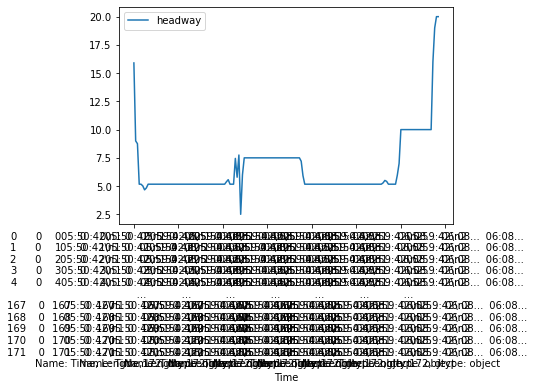

In [40]:
df_headways_example.plot(x=0,y="headway", kind="line" )

<AxesSubplot:ylabel='Time'>

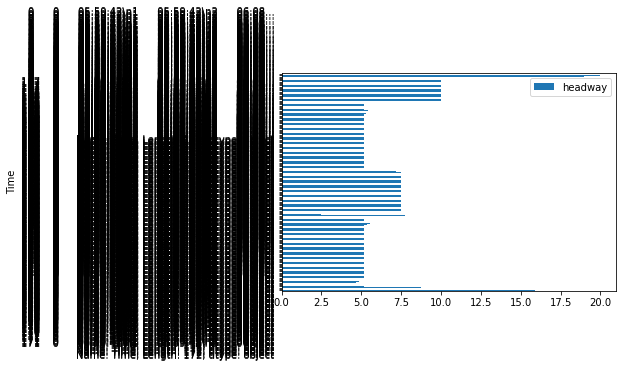

In [42]:
df_headways_example.plot(x=0,y="headway", kind="barh" )

### Calculate distance between points of each line

In [159]:
!pip3 install shapely --user
!pip3 install pyproj --user


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 987.2 kB/s eta 0:00:00:0100:010m
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
#connect to database and get the trips and planned stops for a line
def get_data_from_lines():
    
    #SQL statement
    sql = """Select *
    from actu_lines"""
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [2]:
#connect to database and get the trips and planned stops for a line
def get_data_from_points():
    
    #SQL statement
    sql = """Select *
    from actu_stops"""
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [4]:
from shapely import wkb
import pyproj
import pandas as pd
import numpy as np
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine
import sshtunnel 
import pandas as pd
import psycopg2.extras
import pyproj
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points



In [31]:
lines=get_data_from_lines()
stops=get_data_from_points()

In [21]:
!pip3 install geopy --user

  Using cached geopy-2.3.0-py3-none-any.whl (119 kB)
  Using cached geographiclib-2.0-py3-none-any.whl (40 kB)


In [5]:
import geopy.distance

def calculate_distance_between_each_stop(lines, stops):
    result=[]
    geod = pyproj.Geod(ellps='WGS84')
    
    for index, i in lines.iterrows():
        filter_stops=stops[(stops.code_ligne==str(i["ligne"]))&(stops.variante==i["variante"])]
        filter_stops=filter_stops.sort_values(by=["succession"])
        b=bytes(i["wkb_geometry"])
        merged = wkb.loads(b)
        for j in range(0,len(filter_stops)-1):
            p1 = wkb.loads(bytes(filter_stops.iloc[j]["wkb_geometry"]))
            p2 = wkb.loads(bytes(filter_stops.iloc[j+1]["wkb_geometry"]))
            point1=nearest_points(p1,merged)[0]
            point2=nearest_points(p2,merged)[0]
            
            distance_along_track = abs( merged.project(p1) - merged.project(p2) )
            coords_1 = (point1.x, point1.y)
            coords_2 = (point2.x, point2.y)

            #distance= geopy.distance.geodesic(coords_1, coords_2).km
            distance= point1.distance(point2)
            print(distance_along_track)
            print(distance)
            result.append( {
                                            'code_ligne': filter_stops.iloc[j]["code_ligne"],
                                            'variante': filter_stops.iloc[j]["variante"],
                                            'stop_1': filter_stops.iloc[j]["stop_id"],
                                            'stop_2': filter_stops.iloc[j+1]["stop_id"],
                                            'distance': distance_along_track,
                                            'distance_m': distance

                            })
    df_methods = pd.DataFrame(result)
    df_methods.to_csv("./realability/distance_stops.csv")
    return df_methods


In [41]:
df_methods=calculate_distance_between_each_stop(lines, stops)

third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
508.4244388303874
0.0
828.0493946619498
0.0
586.4870501554096
0.0
611.5878105390779
0.0
390.80006397134593
0.0
587.697286024009
0.0
305.01304890119184
0.0
469.35663412804814
0.0
591.4724676601497
0.0
314.9313099709278
0.0
1218.6788789504749
0.0
703.1153888232002
0.0
525.3199501256415
0.0
415.6648289186967
0.0
577.7973693259419
0.0
749.245387039533
0.0
788.8882557117846


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
514.7913849318171
0.0
424.14697924187533
0.0
834.3685816232489
0.0
872.5589321071775
0.0
410.3678471810538
0.0
531.822423370803
0.0
778.2465033650739
0.0
779.6100692012669


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
567.3631817451881
0.0
396.1806910993953
0.0
533.9528537239956
0.0
707.1585748613685
0.0
1238.3250058042354
0.0
288.6846203038862
0.0
591.3145440457108
0.0
471.50656411126556
0.0
297.15963723222757
0.0
588.8175438962522


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
399.32339024905525
0.0
615.1580691172092
0.0
613.4318544060023
0.0
788.2594750461298
0.0
524.5644002408317
0.0
788.822369104715
0.0
417.34236545074185
0.0
506.43879195812
0.0
496.1429733453886
0.0
672.3953673248848
0.0
697.4901432995472
0.0
454.2006715098451
0.0
404.5108156774056
0.0
433.53675738049566
0.0
600.4657525621338


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
460.87509153781735
0.0
536.5838611065429
0.0
483.7516925034873
0.0
538.9987198500647
0.0
515.8947373253376
0.0
538.2178926791886
0.0
897.8233233771408
0.0
681.2044993979387
0.0
651.2980346968479
0.0
899.7117427265322
0.0
526.9700940281374
0.0
527.1006355526265
0.0
538.2729140501284
0.0
477.8615908398534
0.0
541.6123429169465
0.0
473.43085028334156


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
592.6419492408517
0.0
448.3973349608607
0.0
397.6069667397796
0.0
432.16001666049345
0.0
704.3715070898313
0.0
683.6315528118848
0.0
473.25785783228963
0.0
499.19051473359355
0.0
444.86376566316665
0.0
827.6722177287204


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
861.4297069407435
0.0
519.6836345316096
0.0
387.6090040233897
0.0
547.9023635648965


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
778.1548689046416
0.0
305.2262931007162
0.0
551.4960833949566
0.0
658.9756444664833
0.0
195.49424543960367
0.0
425.73465914816
0.0
630.870034159176
0.0
504.5180373385987
0.0
586.8816320179171
0.0
497.0120722879878
0.0
477.3311219688069
0.0
544.192061684108
0.0
458.956424946857
0.0
538.0612046970085
0.0
402.3038155424285


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
453.1662167461343
0.0
525.2980106568081
0.0
414.1545605205863
0.0
524.0009541976045
0.0
344.095916860401
0.0
82.76472678623425
0.0
75.4254598925323
0.0
438.77215043801493
0.0
427.59092600287954


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
501.52268144122854
0.0
447.1599266481736
0.0
433.99126719324073
0.0
387.79017522366547
0.0
565.650952443289
0.0
505.37214011063173
0.0
547.768199149969
0.0
478.1673347270807
0.0
493.44705896377576
0.0
587.218681582951
0.0
550.7349453230513
0.0
740.3087193867163
0.0
221.04524423746375
0.0
270.4958410031474
0.0
436.71107153357684


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
775.0041290212636
0.0
249.34802986989126
0.0
844.5886572764283
0.0
557.2297551279903
0.0
472.49232798004243
0.0
447.8359074482527
0.0
831.5726065714287
0.0
504.5180373385987
0.0
586.8816320179171
0.0
497.0120722879878
0.0
477.3311219688069
0.0
544.192061684108
0.0
458.956424946857
0.0
538.0612046970085
0.0
402.3038155424285
0.0
453.1662167461343
0.0
525.2980106568081
0.0
414.1545605205863
0.0
535.0240742246967


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
372.87981978112464
0.0
379.00660944104374
0.0
399.6180801715612
0.0
429.17764387255346
0.0
708.34585479129
0.0
375.9494646890723
0.0
256.1637366997971
0.0
174.13213373756292
0.0
173.49792505963305
0.0
229.24441105510076
0.0
378.96965577734585
0.0
715.3601610377846


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
437.5138854939229
0.0
469.73507427059997
0.0
391.72772431882356
0.0
400.4696867429474
0.0
427.59092600287954
0.0
501.52268144122854
0.0
447.1599266481736
0.0
433.99126719324073
0.0
387.79017522366547
0.0
565.650952443289
0.0
505.37214011063173
0.0
547.768199149969
0.0
478.1673347270807
0.0
493.44705896377576
0.0
587.218681582951
0.0
550.7349453230513


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
1011.9888240489804
0.0
610.0357038731422
0.0
599.7667963467161
0.0
502.91431675782326
0.0
540.1863104522229
0.0
673.9608668164768
0.0
732.2001707183751
0.0
623.5021892503457
0.0
592.0779171697133
0.0
507.72115378421915
0.0
828.0493946619498
0.0
586.4870501554096


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
611.5878105390779
0.0
390.80006397134593
0.0
587.697286024009
0.0
305.01304890119184
0.0
469.35663412804814
0.0
591.4724676601497
0.0
314.9313099709278
0.0
1218.6788789504749
0.0
738.1993294497184
0.0
647.8796956225619
0.0
737.8179992383068
0.0
313.02768248191137
0.0
545.0563365377893
0.0
866.6628237094469
0.0
526.3207482134677
0.0
549.3198430786899
0.0
840.232789172155
0.0
527.0700238108747
0.0
334.5314484469315
0.0
715.6769732218781


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
659.0452488258944
0.0
708.0201197706109
0.0
1238.3250058042354
0.0
288.6846203038862
0.0
591.3145440457108
0.0
471.50656411126556
0.0
297.15963723222757
0.0
588.8175438962522
0.0
399.32339024905525
0.0
615.1580691172092
0.0
613.4318544060023
0.0
788.2594750461298
0.0
524.5644002408317
0.0
565.3760960634912
0.0
637.9315088628289
0.0
729.2766004747286
0.0
664.3972080013688
0.0
553.7403362587711
0.0
506.1772811970233


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
622.118766796177
0.0
598.9724618043863
0.0
1035.8287213627666
0.0
537.8718899515062
0.0
859.5562227103168
0.0
563.818765207377
0.0
811.0140381029406
0.0
704.5707913332769
0.0
718.1160421547366
0.0
750.365464290575
0.0
788.822369104715
0.0
417.34236545074185
0.0
506.43879195812
0.0
496.1429733453886
0.0
672.3953673248848
0.0
697.4901432995472
0.0
454.2006715098451


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
404.5108156774056
0.0
433.53675738049566
0.0
600.4657525621338
0.0
460.87509153781735
0.0
536.5838611065429
0.0
483.7516925034873
0.0
538.9987198500647
0.0
515.8947373253376
0.0
538.2178926791886
0.0
897.8233233771408
0.0
681.2044993979387
0.0
651.2980346968479
0.0
899.7117427265322
0.0
526.9700940281374
0.0
527.1006355526265
0.0
538.2729140501284
0.0
477.8615908398534
0.0
541.6123429169465


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
473.43085028334156
0.0
592.6419492408517
0.0
448.3973349608607
0.0
397.6069667397796
0.0
432.16001666049345
0.0
704.3715070898313
0.0
683.6315528118848
0.0
473.25785783228963
0.0
499.19051473359355
0.0
444.86376566316665
0.0
827.6722177287204
0.0
687.7365338557966
0.0
718.5589606984444


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
697.7814915860071
0.0
804.7989189853445
0.0
563.8503347520683
0.0
851.7884537841472
0.0
528.5316452209881
0.0
378.55646870711377
0.0
82.96987405076617
0.0
82.0
0.0
221.18318200080222
0.0
339.05309318748294
0.0
328.16611647152115
0.0
346.4681947884963
0.0
232.9317711262305
0.0
415.9543244155541
0.0
346.18584604226
0.0
232.11415295066487
0.0
507.0839181042928
0.0
419.7951881572727
0.0
332.2483709516284
0.0
485.8474863575853
0.0
497.3932046178355


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
452.38258145070085
0.0
719.5514853017702
0.0
652.0897177536327
0.0
660.7233157684095
0.0
253.74790639530408
0.0
626.0007987215351
0.0
469.8606176303777
0.0
361.33225707096784
0.0
247.8911051248108
0.0
503.1152949374527
0.0
191.81762171396036
0.0
728.6988403997909
0.0
207.23416706711276
0.0
844.5886572764283
0.0
557.2297551279903
0.0
472.49232798004243
0.0
447.8359074482527
0.0
1003.855069220652
0.0
830.5249243701367
0.0
830.319095288074


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
930.4286861441981
0.0
519.6836345316096
0.0
387.6090040233897
0.0
547.9023635648965
0.0
778.1548689046416
0.0
288.9429009337312
0.0
724.7965231704688
0.0
216.6333307688362
0.0
539.8935080180164
0.0
285.56785533389433
0.0
350.03571246374275
0.0
491.30438630242253
0.0
517.4649746601214
0.0
276.9205662279348
0.0
657.8257672058872
0.0
648.9388260845403
0.0
712.9364768336706
0.0
484.4602976509092


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
454.5065236055421
0.0
483.8233148578105
0.0
332.8092546790128
0.0
420.7386362101774
0.0
576.9454046961463
0.0
330.14839087900623
0.0
200.4109777432398
0.0
381.03280698648507
0.0
236.7298037848213
0.0
342.4631367023318
0.0
402.3493506891741
0.0
342.47335662792807
0.0
148.66068747318505
0.0
73.76313442364011
0.0
71.30918594402827
0.0
347.17430780517157
0.0
350.03571246374275
0.0
582.176949045563
0.0
233.8482413874434
0.0
512.2899569579712
0.0
489.3883938141566


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
339.5585369269929
0.0
399.38202262996265
0.0
248.71871662583015
0.0
447.6885077819175
0.0
414.36698710201324
0.0
475.015789211264
0.0
466.0862688387257
0.0
259.500308284977
0.0
553.4265985656996
0.0
302.51280964613716
0.0
444.06305858515185
0.0
407.25913126656843
0.0
456.40004382120736
0.0
419.38049549305464
0.0
534.1329422531436
0.0
454.1156240430404
0.0
306.41801513618617
0.0
503.5434440045864


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
393.6000508130048
0.0
660.4437901895967
0.0
819.5266926708367
0.0
562.19791888621
0.0
399.108205879059
0.0
463.804322963908
0.0
356.5300127618867
0.0
383.91099228858997
0.0
553.2485969254744
0.0
305.34146459332464
0.0
617.7725228593564
0.0
832.4589179052499
0.0
569.0588721740485
0.0
407.1179190357506
0.0
496.71319692554977
0.0
371.29637757457317
0.0
390.1858531520588
0.0
521.7710225759955
0.0
422.35648450094857


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
464.22085261220224
0.0
409.14789502085915
0.0
501.000998002998
0.0
227.7827912727386
0.0
569.0869880782726
0.0
243.28789530101986
0.0
463.2116147075762
0.0
482.83019789569914
0.0
331.409112729267
0.0
211.9929244102265
0.0
409.1771743389439
0.0
200.4109777432398
0.0
316.0142401854701
0.0
398.7580720186113
0.0
536.1488039714401
0.0
467.93369188379035


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
236.61149591682988
0.0
500.6365947471279
0.0
352.7846368537043
0.0
564.8381361062683
0.0
351.78835967096705
0.0
333.6774790122995
0.0
395.26927530481805
0.0
450.3176656539248
0.0
602.3664167265582
0.0
371.9229221223347
0.0
410.3159758040149
0.0
525.1428853179041
0.0
455.17628453161024
0.0
385.2048805505992
0.0
381.28207406064627
0.0
635.6101006119956


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
451.6219658076772
0.0
391.17006531688537
0.0
330.63118425216624
0.0
355.14477329675543
0.0
556.3595959449248
0.0
4247.810847954508
0.0
1417.8067569312823
0.0
1460.4574625780785
0.0
1162.881335304682
0.0
1554.345553601245
0.0
843.51627133092
0.0
511.994140591472
0.0
179.40504452215686
0.0
235.1122497871945
0.0
466.14160938495934
0.0
835.3367285113102
0.0
1524.9883573326172


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
1198.2503578134283
0.0
1618.331823205622
0.0
1165.8883694419442
0.0
4183.084507872151
0.0
243.31255619059203
0.0
213.06337085477645
0.0
330.09241130325915
0.0
327.51946507039855
0.0
477.30074376644336
0.0
427.86039779348414
0.0
442.5369137145486
0.0
273.4702908909851


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
253.18522863705385
0.0
331.85683660277897
0.0
425.6195484232368
0.0
226.03539545832197
0.0
181.89282558693733
0.0
306.4338917286946
0.0
350.0107569775698
0.0
322.8157369150395
0.0
393.88227936783346
0.0
412.64279952520906
0.0
410.6929875222949
0.0
180.08053753806934
0.0
209.15305400591214
0.0
360.1933508547958
0.0
459.33691338709633
0.0
380.63131768155824
0.0
233.60693482857823
0.0
448.6833738840708
0.0
221.50846484954022
0.0
180.62391868188442
0.0
310.17736861350795
0.0
352.54826619910926
0.0
393.9031353010438


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
225.257630281418
0.0
264.03530067018676
0.0
417.0420242613448
0.0
365.0926594715504
0.0
631.4657552076756
0.0
290.0431002454635
0.0
287.75857936819193
0.0
215.23243250030885
0.0
240.66989840858787
0.0
479.00417534714666
0.0
216.69563908856125
0.0
242.36239394757217
0.0
409.6048461627277


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
478.4153530145119
0.0
412.64279952520906
0.0
410.6929875222949
0.0
552.6345989892417
0.0
286.7579641439688
0.0
482.71495729882986
0.0
246.41834347304587
0.0
297.3213749463701
0.0
245.37192178405428
0.0
284.8209613072587
0.0
401.6422786510329
0.0
261.684485592863
0.0
569.1311360310557
0.0
257.9457307264456
0.0
428.05256686533255
0.0
364.21883531744464
0.0
241.11773057990075
0.0
273.72431386341987
0.0
261.283371074395
0.0
264.09278672466615
0.0
208.40585404445815
0.0
225.94247055390008


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
324.4510748941844
0.0
241.72401618374613
0.0
422.78564308641415
0.0
386.80912605574025
0.0
262.17932794177347
0.0
533.0105908891576
0.0
217.14485948324358
0.0
518.1614516731141
0.0
236.27799305057007
0.0
192.22075850438333
0.0
255.6654454555865
0.0
268.60932597360835
0.0
597.1620969217716
0.0
389.0514104845271
0.0
363.79252328765637
0.0
360.1933508547958
0.0
473.0627548222109
0.0
474.3752523056121
0.0
421.5658904607795
0.0
248.90962215229848
0.0
213.9369065869655
0.0
422.99130014693
0.0
360.06943774777665


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
366.9604883362785
0.0
293.53194034039973
0.0
542.2001475470105
0.0
326.5348373451139
0.0
197.6689151080665
0.0
338.92329515688357
0.0
354.79007877898727
0.0
263.8730755495907
0.0
254.691970819655
0.0
222.80035906613796
0.0
191.45623520794211
0.0
591.105828088361
0.0
210.92949058870838
0.0
286.5095111859161
0.0
296.7237772744207
0.0
228.77936969928035
0.0
295.6112311804137


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
253.74396544548603
0.0
401.2605138809449
0.0
291.48070262025925
0.0
276.21187519728403
0.0
296.90570893803977
0.0
575.127811881846
0.0
228.7575135378071
0.0
208.90428430264421
0.0
408.8275920238261
0.0
325.40590037674485
0.0
507.70463854489253
0.0
446.2298174707801
0.0
391.4792459377636
0.0
400.35983814563616
0.0
333.65401241405743
0.0
494.83835744614623
0.0
474.6578241217669
0.0
334.5845931898119
0.0
309.02588888311607


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
504.5711049990873
0.0
279.30807363912703
0.0
547.7666017566328
0.0
351.78835967096705
0.0
291.30357018069276
0.0
356.32587613024833
0.0
430.95245677451874
0.0
245.91709985277882
0.0
391.637587573001
0.0
333.7573969217761
0.0
307.8002599089221
0.0
558.1290173427645
0.0
825.8189874300542
0.0
920.8806654502034
0.0
456.1633479358025
0.0
378.80337907679757


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
278.53904573685895
0.0
286.2044723619811
0.0
315.75306807693886
0.0
409.9268227379126
0.0
423.0957338475537
0.0
282.8041902094041
0.0
355.14477329675543
0.0
515.8730463980455
0.0
327.33163611236847
0.0
461.4066536147783
0.0
387.5106450150887
0.0
364.3212867785795
0.0
369.58354941744903
0.0
499.3085218579791
0.0
286.75425018646195
0.0
455.7630963559906
0.0
391.56736329781114
0.0
459.6754724803144
0.0
398.8307911884437
0.0
253.65330670030698


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
418.7182823808867
0.0
280.0803456153252
0.0
497.4193401949707
0.0
357.35744010723386
0.0
433.34974327901506
0.0
400.1954772358181
0.0
405.4281687302943
0.0
481.8087794966077
0.0
413.29825792032966
0.0
484.46098914155215
0.0
329.0340559881279
0.0
379.03416732533464
0.0
676.1570009990133
0.0
241.11773057990075
0.0
273.72431386341987
0.0
261.283371074395
0.0
264.09278672466615
0.0
102.7861858422619


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
136.20939761998804
0.0
237.19190542680835
0.0
225.94247055390008
0.0
324.4510748941844
0.0
241.72401618374613
0.0
633.7523175500031
0.0
352.0127838587684
0.0
388.73667179724515
0.0
444.4758036159173
0.0
505.89150022509216
0.0
367.2972229680014
0.0
427.907700328003
0.0
409.2752252458054
0.0
511.8007913241256
0.0
270.0743971575076
0.0
386.3275812053807
0.0
343.6800837988725


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
373.9478573277296
0.0
259.0598386473673
0.0
311.8092365533773
0.0
376.36418533117626
0.0
646.8237781652743
0.0
266.32686683847726
0.0
636.9621024833342
0.0
683.3398276114244
0.0
271.93013808697265
0.0
221.22612865572637
0.0
297.1683024819437
0.0
236.93247983339052
0.0
289.1816038409082
0.0
356.3509506090871
0.0
526.8519716201126


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
335.0
0.0
285.2367437761131
0.0
412.8692286911196
0.0
259.4672426338246
0.0
499.2617049203754
0.0
229.89562849258357
0.0
216.69563908856125
0.0
329.4753405036559
0.0
322.0636583037583
0.0
360.7173408640067
0.0
305.8131782641033
0.0
324.60945765644055
0.0
508.8940950728225
0.0
157.1655178466338
0.0
298.2029510249689


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
88.54377448471462
0.0
314.8205838251368
0.0
280.515596714336
0.0
399.1190925024887
0.0
253.701182496251
0.0
396.62861722270634
0.0
167.5857989210303
0.0
340.4776057246644


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
180.22763384120648
0.0
232.13142829009604
0.0
62.2826621139444
0.0
602.2542071252008
0.0
477.1299613312918
0.0
299.8216136305053
0.0
324.8584307048226
0.0
487.03695958315114
0.0
386.5126129895375
0.0
306.8061277093403
0.0
173.35801106380978
0.0
334.22896343674347
0.0
263.8560213449752
0.0
265.03018695990085
0.0
529.5903794443482


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
701.6290829205902
0.0
404.44868648569786
0.0
645.4387190121104
0.0
243.28789530101986
0.0
463.2116147075762
0.0
482.83019789569914
0.0
331.409112729267
0.0
211.9929244102265
0.0
453.5848762910921


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
232.11415295066487
0.0
507.0839181042928
0.0
419.7951881572727
0.0
332.2483709516284
0.0
485.8474863575853
0.0
497.3932046178355
0.0
452.38258145070085
0.0
719.5514853017702
0.0
652.0897177536327
0.0
811.528989007785
0.0
368.41959774148825
0.0
516.5471904869873
0.0
459.0642656535139
0.0
530.9736339970187
0.0
219.16432191394657
0.0
402.6164427839479
0.0
196.5400722499104
0.0
615.4965475126567
0.0
459.35824799387245
0.0
532.6922188280959
0.0
624.7431472213201
0.0
171.14321488157222


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
379.17829579236695
0.0
215.79383679800307
0.0
439.27326347047347
0.0
548.5471720827662
0.0
504.38576506479643
0.0
421.16505078175703
0.0
163.37074401495514
0.0
657.8257672058872
0.0
648.9388260845403
0.0
712.9364768336706
0.0
484.4602976509092
0.0
454.5065236055421
0.0
483.8233148578105
0.0
332.8092546790128
0.0
420.7386362101774
0.0
576.9454046961463
0.0
258.3834360016137
0.0
447.6885077819175
0.0
414.36698710201324
0.0
475.015789211264
0.0
466.0862688387257
0.0
259.500308284977
0.0
88.54377448471462
0.0
314.8205838251368
0.0
573.6172940210256
0.0
455.2513591412969
0.0
422.8392129403327
0.0
719.3691680910435


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
201.30076999355964
0.0
387.9226727068167
0.0
404.61957441527716
0.0
406.9262832504187
0.0
319.00626953086675
0.0
334.0688551780905
0.0
263.07793522072507
0.0
222.80035906613796
0.0
383.7127180587005
0.0
186.3299492835349
0.0
302.33259830855155
0.0
224.45890492469712
0.0
69.87603308718077
0.0
59.726208652476835
0.0
246.59480935331953
0.0
308.1368040335219
0.0
162.32467464930613
0.0
399.8210224587938
0.0
195.7268504830137


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
277.34635386101615
0.0
249.99399992799826
0.0
417.40388115109806
0.0
397.6053319562
0.0
417.50209580312287
0.0
416.3807512361842
0.0
577.2329945524743
0.0
428.04906260848185
0.0
483.1997516555653
0.0
310.57688259109045
0.0
508.8940950728225
0.0
157.1655178466338
0.0
298.2029510249689
0.0
312.68330623812795
0.0
375.2026119312071
0.0
264.1685068285014


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
325.85272747055535
0.0
364.97260171141613
0.0
424.3170984063687
0.0
415.7799898985039
0.0
406.9262832504187
0.0
306.08005488760614
0.0
279.54427198567316
0.0
268.53118999475646
0.0
288.19611378365255
0.0
187.51533270642165
0.0
245.20399670478457
0.0
178.98603297464302
0.0
233.13729860320507
0.0
396.8526174790838
0.0
157.54364474646383
0.0
135.50645741070792
0.0
386.7453942841466
0.0
293.5745220553037
0.0
221.56263222845138
0.0
242.54690268069803
0.0
155.46382215808282
0.0
346.2860089579133
0.0
177.341478509682
0.0
299.23402212983734
0.0
324.4456811239749


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
397.6053319562
0.0
375.969413649568
0.0
345.2723562638631
0.0
388.29112789246165
0.0
262.8174271238496
0.0
360.25685281476603
0.0
331.76045575083236
0.0
340.7900379999505
0.0
118.77011408598257
0.0
446.4011648730321
0.0
263.24513290847375
0.0
338.3858744096745
0.0
173.92527130926086
0.0
307.46707140765494
0.0
147.05441169852742


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
317.58620876857987
0.0
488.9263748254946
0.0
282.4694673765644
0.0
273.99635034065693
0.0
240.9024698918631
0.0
248.51961693194363
0.0
334.7177915797127
0.0
232.13142829009604
0.0
452.0099556425721
0.0
407.49233121618374
0.0
292.86515668477875
0.0
191.049731745428
0.0
340.7007484582328
0.0
263.07793522072507
0.0
251.46172671005024
0.0
371.6728938192938
0.0
338.5875662218019
0.0
354.1073283624613
0.0
359.83607378916304


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
170.63753983223455
0.0
269.77837200190817
0.0
268.41199675126296
0.0
378.85749299703707
0.0
289.4995682207488
0.0
245.81497106563708
0.0
376.80574570990433
0.0
423.1037343252905
0.0
220.41097976280582
0.0
282.21445746098834
0.0
307.2783754187723
0.0
268.31511325305553
0.0
136.06616037795732
0.0
402.20392837464925
0.0
534.3079636314623
0.0
229.89562849258357
0.0
216.69563908856125
0.0
343.3729750577351
0.0
275.77164466275354
0.0
294.7032405658275
0.0
282.4535360019414
0.0
232.1055794245369
0.0
321.56647835245514


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
229.92390045404153
0.0
313.26985172531363
0.0
231.12033662142
0.0
300.17863015211526
0.0
169.2498744460434
0.0
156.7226850203888
0.0
179.9388785115657
0.0
375.10798445247735
0.0
251.73154351411912
0.0
71.81761622332698
0.0
233.44789568553367
0.0
256.2225595063791
0.0
277.89386463180506
0.0
287.862814548875
0.0
574.228177643696
0.0
500.89619683123965
0.0
267.1521289452845
0.0
230.29342153001647
0.0
499.16830828889766
0.0
383.89191187103694
0.0
332.4830822763769


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
288.2117277280715
0.0
196.5400722499104
0.0
630.870034159176
0.0
504.5180373385987
0.0
586.8816320179171
0.0
497.0120722879878
0.0
477.3311219688069
0.0
544.192061684108
0.0
454.6702101523697
0.0
309.84512260159914
0.0
390.14484489737913
0.0
344.06104109590785
0.0
270.20177645604036
0.0
365.9781414237741
0.0
458.57714727186305
0.0
268.9014689435519


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
395.06581730137066
0.0
167.2602762164406
0.0
274.3519637254306
0.0
255.38402455909414
0.0
457.1214280691729
0.0
497.43843840218057
0.0
171.1724276862369
0.0
265.32432983049256
0.0
301.09466949781756
0.0
350.52674648306083
0.0
313.9681512510465
0.0
384.0963420809941
0.0
213.94882565698663
0.0
212.19059828370524


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
258.3118270617898
0.0
412.4427232962172
0.0
374.9306602559999
0.0
283.28960446864266
0.0
284.5224068504975
0.0
186.20687420178666
0.0
454.00991178607546
0.0
503.45704881350105
0.0
125.67418191498204
0.0
328.70959827787203
0.0
190.14205216100936
0.0
376.19808611953357
0.0
368.8604072003391
0.0
468.89764341485017
0.0
279.30807363912703
0.0
380.2538625707831
0.0
238.949785519887
0.0
371.856154984693
0.0
295.11523173160685
0.0
488.5949242470699
0.0
547.768199149969
0.0
478.1673347270807
0.0
493.44705896377576
0.0
587.218681582951


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
550.7349453230513
0.0
621.6630920361929
0.0
171.14321488157222
0.0
168.37161280928564
0.0
528.0151512977634
0.0
389.52406857599954
0.0
385.8108344772085
0.0
321.38606068092
0.0
312.6739515853535
0.0
375.32918884627134
0.0
612.2777147667551
0.0
319.4761336938958
0.0
280.4460732476032


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
280.22312538404105
0.0
240.58470441821524
0.0
348.05890306096177
0.0
302.27305536550887
0.0
450.5208097302499
0.0
195.72429588581997
0.0
112.05449567063437
0.0
243.36435646988645
0.0
262.7149215404406
0.0
360.48256545915194
0.0
540.8003883134667
0.0
239.43544015035795
0.0
199.56452590580727
0.0
328.6281333057162
0.0
356.46566454569177
0.0
299.8752073780119
0.0
213.0203041965614
0.0
209.1864479357988
0.0
269.2675249635574
0.0
187.5032266389057
0.0
166.69028166033152
0.0
257.3613801641536


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
335.3517108946902
0.0
330.6055050963308
0.0
261.50334605889844
0.0
429.66033095923575
0.0
360.0347205478938
0.0
433.5862082677446
0.0
288.5550207499429
0.0
363.5519220138989
0.0
456.86321804233705
0.0
297.6071235706565
0.0
407.265269818088
0.0
493.7769233165795
0.0
301.86362815020914
0.0
279.2597357300189
0.0
404.623281584241
0.0
232.7230113246217
0.0
251.81342299408902
0.0
387.5835393821569


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
329.95151158920305
0.0
346.3596396810691
0.0
339.0368711512068
0.0
547.9124930132543
0.0
205.56702070128532
0.0
409.5072404732276
0.0
306.93647551244214
0.0
423.76998477947916
0.0
234.82759633399138
0.0
475.2283661567352
0.0
557.2162955262526
0.0
345.0057970527452
0.0
285.0491185743257
0.0
239.47024867402632
0.0
317.54993308139285
0.0
217.5030114734102
0.0
293.1381926668717
0.0
391.1521443121589
0.0
198.59506539690256
0.0
317.81283800375337
0.0
415.5309856075717


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
375.66474415361364
0.0
273.99452549275503
0.0
222.69710370815332
0.0
240.4100663449848
0.0
388.0012886576538
0.0
363.14184556451215
0.0
262.33756879257686
0.0
362.17399133565624
0.0
369.27886481626723
0.0
459.7180440226543
0.0
294.8236761184556
0.0
491.3623510201035
0.0
386.43830037924465
0.0
393.3675126392621
0.0
275.1817581163403
0.0
435.8084441586693
0.0
414.23785437837523
0.0
293.027302482209
0.0
500.62460986251966
0.0
475.42927970414274
0.0
543.0616907865993
0.0
549.4160536424104


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
216.83173199511182
0.0
248.96586111352696
0.0
398.45325949225213
0.0
430.4195627524381
0.0
222.97085011274456
0.0
311.30692250574833
0.0
395.6425154100605
0.0
500.32089702509927
0.0
517.150848399188
0.0
500.6006392325124
0.0
399.04009823575376
0.0
298.0620740718282
0.0
445.0
0.0
248.80916381837707
0.0
412.43787410954394


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
390.96930825833374
0.0
367.0490430446591
0.0
645.4339625399333
0.0
317.9701243827791
0.0
336.29154018500077
0.0
383.98567681620625
0.0
212.52999788265186
0.0
438.46322536787505
0.0
477.91317203023397
0.0
183.0027322200409
0.0
203.1206537996567
0.0
210.1927686672403
0.0
459.1786144846034
0.0
413.0298899595635
0.0
303.99113473913445
0.0
211.82431399630383
0.0
254.11808278829744
0.0
221.92115717073935
0.0
322.41588050218616
0.0
266.101484400219


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
258.0896355919724
0.0
458.38002792443956
0.0
448.41655857027087
0.0
274.2105030810996
0.0
524.555621454954
0.0
381.66215426735727
0.0
225.50388023269133
0.0
71.70955305954304
0.0
461.1397402089731
0.0
353.41194094144583
0.0
446.21295364433337
0.0
144.84474446799925
0.0
383.7303740909755
0.0
291.23358322830836
0.0
828.3217973710459
0.0
514.5133623143329
0.0
445.8261993198695


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
596.2591718372138
0.0
343.3496759864497
0.0
437.79888076603964
0.0
354.85188459412586
0.0
294.21505739850295
0.0
318.9545422156581
0.0
337.843158877015
0.0
593.2486831000975
0.0
431.6769625541766
0.0
509.01203325658224
0.0
752.9356944653431
0.0
370.55365333510844
0.0
345.2535300326414
0.0
205.7668583615933
0.0
443.81302369353693
0.0
335.9077254247065


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
389.3712881042977
0.0
216.6702563805194
0.0
529.1814433632381
0.0
490.8358686974737
0.0
379.5835744602204
0.0
453.5678339564999
0.0
408.2081944302297
0.0
264.9506557833083
0.0
295.2185631019838
0.0
301.21254953935767
0.0
215.9837956884729
0.0
182.0988742414406
0.0
623.3177359902412
0.0
166.69028166033152
0.0
257.3613801641536
0.0
419.753225121612
0.0
312.00160255998685
0.0
249.57563983690395


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
337.4640721617636
0.0
306.56239169212085
0.0
267.97136041003955
0.0
448.2108990196455
0.0
250.9764132343856
0.0
232.89416051074645
0.0
367.856887933338
0.0
359.6845840455312
0.0
243.47895186237352
0.0
371.1711195661645
0.0
437.95091049111886
0.0
376.14491888100787


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
529.1814433632381
0.0
517.4263232577175
0.0
547.7809781290329
0.0
381.66215426735727
0.0
225.50388023269133
0.0
277.7516876636396
0.0
431.8564576337837
0.0
435.12986567230706
0.0
176.81911661356077
0.0
383.5374818710682
0.0
455.96491093065487
0.0
602.7470447874465
0.0
244.77111757720775
0.0
294.2578800984031
0.0
314.2005728829914
0.0
275.0163631495406
0.0
305.19665791092797
0.0
454.84502855368225
0.0
239.47024867402632
0.0
317.54993308139285


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
217.5030114734102
0.0
159.66527487215245
0.0
443.6800649116433
0.0
412.97578621512423
0.0
228.47691349455607
0.0
265.75364531836624
0.0
503.16001430956334
0.0
447.6159067772279
0.0
516.4672787311946
0.0
585.1253284553624
0.0
426.1983106489278
0.0
650.1545969998213
0.0
527.274122255208
0.0
686.3701625216528
0.0
307.7092783781471
0.0
362.72992708074145
0.0
141.2834031300209
0.0
464.02693887316497
0.0
441.955880150949


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
358.23037280498704
0.0
459.07080063972705
0.0
643.2122511271066
0.0
371.6463372616499
0.0
375.8594684187223
0.0
650.6027974117542
0.0
463.03563577763646
0.0
355.12392203285884
0.0
442.0904884749275
0.0
465.15051327500436
0.0
141.2834031300209
0.0
397.25684386804465
0.0
365.1410686296462
0.0
565.0601737868278
0.0
585.6423823460867
0.0
619.4586346157425
0.0
424.19924563817887
0.0
659.3034202853797
0.0
451.2427284732686
0.0
521.1880658649045
0.0
378.6357088284199


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
280.17316074170986
0.0
224.71337298879544
0.0
547.7809781290329
0.0
381.66215426735727
0.0
225.50388023269133
0.0
277.7516876636396
0.0
499.88498677195736
0.0
395.4554336458155
0.0
391.0818328687744
0.0
209.69024774652732
0.0
871.4370946889946
0.0
259.500308284977
0.0
249.68980756130196
0.0
363.90245945857527
0.0
237.65521244020718
0.0
389.39600665645446
0.0
285.8420018121782
0.0
288.9221348391293
0.0
308.46879907050567


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
408.0012254883556
0.0
209.124364912365
0.0
276.7959537276512
0.0
192.86523792534516
0.0
256.2537804599183
0.0
422.9952718411874
0.0
266.68040797929206
0.0
314.33141745615455
0.0
188.95766721676048
0.0
232.1055794245369
0.0
280.0
0.0
297.59368272864936
0.0
411.4608122288197
0.0
239.42639787625757
0.0
223.46364357541475
0.0
229.5952961190625
0.0
178.4628812946827
0.0
357.76109346881196
0.0
296.3258341758275


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
281.88827574058485
0.0
276.3222756130964
0.0
409.4691685585131
0.0
268.7452325158532
0.0
325.7299494980466
0.0
277.02887936097926
0.0
243.1810025474852
0.0
877.1100273055827
0.0
168.58232410309213
0.0
306.413119823548
0.0
506.9571185021553
0.0
515.1998835403552
0.0
376.14491888100787
0.0
529.1814433632381
0.0
517.4263232577175
0.0
299.9054017519403
0.0
189.37330857331335
0.0
316.22776601683796
0.0
537.1126511263722
0.0
430.4427952701729
0.0
188.0069413612177
0.0
575.989939148248


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
310.0541404335747
0.0
336.1859158263401
0.0
289.4995682207488
0.0
245.81497106563708
0.0
376.80574570990433
0.0
328.3769937130318
0.0
354.1073283624613
0.0
267.6060537431842
0.0
344.0058139043583
0.0
198.5605197414781
0.0
376.7363534356466
0.0
187.90827549631283
0.0
563.5960610224321
0.0
505.69259436934607
0.0
387.1499192819186
0.0
202.6570008660008
0.0
250.4156544627352
0.0
354.2724939929715
0.0
216.6702563805194
0.0
529.1814433632381


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
490.8358686974737
0.0
434.3183394700243
0.0
289.0049307538033
0.0
448.6946623261619
0.0
282.81591185788346
0.0
286.978814549077
0.0
355.92414922283655
0.0
335.5294323900662
0.0
356.6791275081849
0.0
235.00851048419503
0.0
337.6270131372785
0.0
343.6771741038383
0.0
226.37385007989892
0.0
299.78745804320033
0.0
318.9545422156581
0.0
337.843158877015
0.0
593.2486831000975
0.0
431.6769625541766
0.0
509.01203325658224
0.0
640.152520888577
0.0
851.5071931581083


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
330.3303195287992
0.0
315.73933869568316
0.0
524.6442032463681
0.0
193.36899958369364
0.0
352.4769496009633
0.0
272.20933121405585
0.0
137.39261261069763
0.0
361.99106342558974
0.0
347.8692283028207
0.0
329.3597577118463
0.0
313.7793651596508
0.0
390.0500737084946
0.0
570.3165787525381
0.0
606.6836078220673
0.0
697.4847668587465
0.0
514.5133623143329
0.0
445.8261993198695
0.0
596.2591718372138
0.0
343.3496759864497
0.0
437.79888076603964
0.0
354.85188459412586


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
210.52201785085813
0.0
320.89041743249226
0.0
340.5957427802086
0.0
202.8108724896062
0.0
348.37860152427214
0.0
406.63620104461927
0.0
303.4237960345233
0.0
267.6191323504357
0.0
330.13609314948
0.0
420.01691632599557
0.0
332.9730469572478
0.0
466.1214434029097
0.0
495.61376090661565
0.0
381.66215426735727
0.0
225.50388023269133
0.0
71.70955305954304
0.0
417.3045171095081
0.0
228.47691349455607
0.0
265.75364531836624
0.0
503.16001430956334
0.0
447.6159067772279


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
516.4672787311946
0.0
585.1253284553624
0.0
426.1983106489278
0.0
612.7291408118273
0.0
438.525939939703
0.0
464.38453893298384
0.0
727.3300488773992
0.0
675.24365972588
0.0
531.4216781426968
0.0
1297.8289563729113
0.0
662.85820504841
0.0
594.6873127955564
0.0
642.2413876417495
0.0
665.0864605447927
0.0
1268.298466450228
0.0
541.6013293927555
0.0
643.3941249343205
0.0
733.845351555762
0.0
497.6916716200905


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
442.3324541563732
0.0
615.7052866428872
0.0
424.19924563817887
0.0
659.3034202853797
0.0
451.2427284732686
0.0
521.1880658649045
0.0
378.6357088284199
0.0
280.17316074170986
0.0
224.71337298879544
0.0
318.29183150060067
0.0
354.1073283624613
0.0
312.70753108935514
0.0
566.3585436805911


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
227.65983396286663
0.0
787.20835869546
0.0
269.27170293218705
0.0
187.24115466424576
0.0
212.0
0.0
490.6862541380184
0.0
369.3846233940985
0.0
334.22896343674347
0.0
263.8560213449752
0.0
265.03018695990085
0.0
286.9276041094681
0.0
284.8762011822078
0.0
204.02205763103166
0.0
149.40548852033515
0.0
148.83984681528892
0.0
221.4788928995148
0.0
229.8222138958736
0.0
336.6883573870733
0.0
271.93013808697265
0.0
221.22612865572637
0.0
297.1683024819437


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
573.1710041514661
0.0
306.13885738337757
0.0
293.82477771624366
0.0
431.07423954581185
0.0
724.5757379322054
0.0
290.5942188000305
0.0
501.01596780941026
0.0
289.4995682207488
0.0
245.81497106563708
0.0
376.80574570990433
0.0
460.5659561886875
0.0
428.6268773653841
0.0
240.86510747719356
0.0
448.5888986588946


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
317.0678160898706
0.0
343.17633951075356
0.0
438.80291703679455
0.0
366.69878647194895
0.0
510.3067704822267
0.0
403.56041679034735
0.0
179.04390522997008
0.0
292.48187978062083
0.0
412.9259497779164
0.0
559.0921212108072
0.0
417.94377612305703
0.0
282.3118842698621


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
394.32093527988087
0.0
465.7507058502516
0.0
387.82537307400855
0.0
467.6109494013159
0.0
328.1249761904753
0.0
190.74642853800682
0.0
284.53247617800616


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
175.06984320549532
0.0
334.9940297975473
0.0
221.14248800264502
0.0
613.7271380670729
0.0
157.69908052997647
0.0
326.73230633042704
0.0
371.7216700704978
0.0
319.8280788173546
0.0
363.40198128243605
0.0
348.9068643635433
0.0
573.5015257172382
0.0
427.8001870032317
0.0
300.0
0.0
180.23595645708434
0.0
454.5283269500373
0.0
246.0894146443524
0.0
379.7222669267632


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
314.00636936215164
0.0
529.0604880351584
0.0
296.24314338056837
0.0
288.29325347638644
0.0
455.24169404833737
0.0
564.4289149219767
0.0
426.20300327426133
0.0
456.03947197583676
0.0
405.6858390429718
0.0
477.2197083105529
0.0
358.7506794418541
0.0
517.2823213681287
0.0
392.587569849072


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
371.94892122440683
0.0
397.5223264170203
0.0
387.07234465923807
0.0
254.939208439973
0.0
329.9893937689513
0.0
720.8002497224873
0.0
373.6000535331867
0.0
504.7771785649585
0.0
200.55173896029922
0.0
366.3249923223912
0.0
783.7512360436824
0.0
381.32204237363464
0.0
270.14138890587583
0.0
402.03972440542304
0.0
407.8588603916801
0.0
271.6615541441225
0.0
746.7340155637688
0.0
303.8945376277755
0.0
322.5926223582926


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
167.14664220378464
0.0
427.3265730094491
0.0
427.73871697567483
0.0
665.3860608699326
0.0
329.0185557077342
0.0
294.126180405617
0.0
343.7586362551492
0.0
375.11065034200243
0.0
373.0
0.0
396.5904688718578
0.0
447.017896733453
0.0
549.563463123232
0.0
349.9028436580646
0.0
445.1179618932492
0.0
423.49144029130036
0.0
395.8307719215372
0.0
220.5810508633958
0.0
466.22848475827817


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
423.6271945944925
0.0
355.9561349380087
0.0
373.8707931893051
0.0
375.27889628913357
0.0
287.6231562305242
0.0
457.52798821493457
0.0
354.81224612460977
0.0
297.578561055732


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
265.63508804372964
0.0
322.41588050218616
0.0
266.101484400219
0.0
289.0155705148081
0.0
281.60255680657446
0.0
182.8421176862612
0.0
358.058151701651
0.0
408.06494581132546
0.0
303.7795253140014
0.0
239.30106560565082
0.0
332.0316249997882
0.0
525.0009523800885
0.0
254.53094114468678
0.0
367.1359966007262
0.0
339.22206590963594
0.0
182.60024644012873
0.0
285.41373477812874


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
280.349781523011
0.0
295.2185631019838
0.0
301.21254953935767
0.0
275.82965757873103
0.0
222.08106627986098
0.0
400.61355443868234
0.0
413.17850863761964
0.0
376.3655802540788


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
338.6460246334083
0.0
261.51399580137036
0.0
589.957193362354
0.0
270.3301684976965
0.0
364.71632812365283
0.0
468.01816204074817
0.0
195.01633264933702
0.0
356.46566454569177
0.0
190.07893097342483
0.0
410.90266487332497
0.0
177.451401797788
0.0
286.6443789785524
0.0
393.2047812527208
0.0
345.9277381188158
0.0
246.34325645326686


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
354.1708627202413
0.0
339.7131142596647
0.0
422.6829071538102
0.0
381.7253462897129
0.0
529.3203188996243
0.0
267.41914665932205
0.0
190.41517796645678
0.0
214.67263449261176
0.0
439.0649154737828
0.0
277.1154993860863
0.0
223.2576986354558
0.0
392.10330271498606
0.0
305.7973184970725
0.0
263.46346995361614
0.0
397.45188388030067
0.0
486.3106003368629


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
638.6245923858552
0.0
207.55811234447077
0.0
259.6690201005888
0.0
408.0012254883556
0.0
448.44732132102206
0.0
300.1016494456503
0.0
322.20659521492195
0.0
35.21775120588641
0.0
351.5156468779268
0.0
278.7569730069453
0.0
412.6414908852477
0.0
459.91847103590004
0.0
247.97580527140144
0.0
296.52150006365474
0.0
534.4389581607987
0.0
626.7256177945816
0.0
366.3986899539899
0.0
331.05437619823124
0.0
307.09281984442424
0.0
278.28941769316344


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
276.24083695210595
0.0
312.5331982366033
0.0
476.3884969224173
0.0
246.0894146443524
0.0
394.8595952993795
0.0
214.2281494108565
0.0
269.41930146149747
0.0
500.8628155493233
0.0
435.0195397910305
0.0
440.4463644985618
0.0
386.51778743028115
0.0
278.3522947633089
0.0
380.0
0.0
239.7269279826528
0.0
362.4941378836353
0.0
305.35389304870506
0.0
286.6443789785524
0.0
393.2047812527208
0.0
345.9277381188158


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
246.34325645326686
0.0
354.1708627202413
0.0
367.4274894451927
0.0
577.6092970165809
0.0
511.0134440501657
0.0
261.0381198216166
0.0
459.50918380377175
0.0
494.6151332096428
0.0
172.90459797240788
0.0
433.94208138876576
0.0
305.2863082419354
0.0
281.44271175498574
0.0
793.0529616614517
0.0
356.97618968216915
0.0
442.417223896177
0.0
361.7319449537185
0.0
314.75863768926183
0.0
675.5301621689441
0.0
433.94124026185847
0.0
634.20580255939
0.0
156.1569723067145
0.0
560.1321272699862
0.0
338.64730915806786
0.0
712.0849668403343
0.0
277.2760357477725


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
428.22540793371894
0.0
325.39975414864716
0.0
495.0646422438185
0.0
700.7859873028284
0.0
326.683332908185
0.0
293.97278785629123
0.0
428.5907138518052
0.0
185.23498589629335
0.0
453.61768043143996
0.0
502.9612311103113
0.0
123.8789731956154
0.0
670.7805155190482
0.0
559.6771390721618
0.0
386.51778743028115


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
278.3522947633089
0.0
380.0
0.0
239.7269279826528
0.0
362.4941378836353
0.0
305.35389304870506
0.0
346.1038283521343
0.0
371.9099353338117
0.0
343.68153863715173
0.0
450.31544499383983
0.0
286.2044723619811
0.0
255.80656754665233
0.0
391.89697625778
0.0
421.28167536696867
0.0
342.7723588622742
0.0
256.5345980564805
0.0
523.3096597617896
0.0
214.98139454380697
0.0
314.416920664267
0.0
311.44823004794875
0.0
278.10789273229915
0.0
371.6923997070791
0.0
436.6982482218177
0.0
309.09053689816835
0.0
380.56465942070315


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
482.1830565252132
0.0
445.1539059696096
0.0
538.0612046970085
0.0
402.3038155424285
0.0
453.1662167461343
0.0
525.2980106568081
0.0
414.1545605205863
0.0
535.0240742246967
0.0
372.87981978112464
0.0
379.00660944104374
0.0
399.6180801715612
0.0
429.17764387255346
0.0
269.51068624455735
0.0
448.04921604661746
0.0
302.8516798698706
0.0
335.1343163568842
0.0
349.67620736904036
0.0
317.7247236209357
0.0
474.1867248247164
0.0
434.2790001830524
0.0
282.25697511310506
0.0
357.53181676600474


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
265.70660511172844
0.0
332.05698306164584
0.0
420.01691632599557
0.0
210.30646685254305
0.0
150.9270022229339
0.0
437.5138854939229
0.0
469.73507427059997
0.0
391.72772431882356
0.0
400.4696867429474
0.0
427.59092600287954
0.0
501.52268144122854
0.0
447.1599266481736
0.0
433.99126719324073


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
387.79017522366547
0.0
565.650952443289
0.0
474.98210492606984
0.0
567.824796922431
0.0
302.5797911295383
0.0
309.00661805211064
0.0
433.25385168513617
0.0
354.0941259043988
0.0
292.630569148194
0.0
349.3436703305214
0.0
308.8462400612965
0.0
210.440015206234
0.0
505.22272316276513
0.0
260.86394921491166


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
355.7555340398797
0.0
486.43228716852923
0.0
312.9040907370752
0.0
157.78466338652817
0.0
397.31096133884853
0.0
417.44101379715914
0.0
334.1212354819729
0.0
324.00771595750615
0.0
343.5823773129325
0.0
238.5872586707175
0.0
467.48796775959914
0.0
466.22848475827817


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
423.6271945944925
0.0
145.4698594211267
0.0
300.20906048950445
0.0
432.560978360277
0.0
381.2033578026301
0.0
245.5402207378661
0.0
469.6173761691564
0.0
421.61533416137496
0.0
513.1141490935314


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
511.0134440501657
0.0
261.0381198216166
0.0
246.50050709886034
0.0
265.1129759178115
0.0
67.40066765247106
0.0
224.25942566591863
0.0
217.0112669885969
0.0
123.8789731956154
0.0
670.7805155190482
0.0
526.8930157062248
0.0
297.79204153232894
0.0
515.9725283384895
0.0
238.933045014707
0.0
385.9663197741482
0.0
371.19159473243485
0.0
269.58827867694765
0.0
270.3301684976965
0.0
364.71632812365283
0.0
468.01816204074817


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
284.39760899135564
0.0
369.5437727793598
0.0
172.26769865531992
0.0
177.60191440409488
0.0
487.5910171444917
0.0
355.81034273893727
0.0
588.836989327267
0.0
486.3106003368629
0.0
638.6245923858552
0.0
207.55811234447077
0.0
259.6690201005888
0.0
532.7682422967796
0.0
311.6167517961767
0.0
400.9750615686716
0.0
234.95744295510198
0.0
151.2679741386127
0.0
396.72786642735343
0.0
386.35864167894573


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
389.23643200502187
0.0
288.7806433956391
0.0
402.7498727498259
0.0
234.17301296263838
0.0
159.80300372646317
0.0
446.37428241331287
0.0
420.1166504674624
0.0
517.9436745438749
0.0
721.4735268878487
0.0
387.4183785005559
0.0
197.56204088841992
0.0
472.47027419722974
0.0
338.49224511057855


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
356.74220383913087
0.0
125.29964086141668
0.0
447.32352945043743
0.0
513.3680356235775
0.0
361.95165423023
0.0
614.7161946784873
0.0
105.9000000000045
0.0
430.2987450597495
0.0
440.62779077131364
0.0
563.0717982637609
0.0
349.9028436580646
0.0
134.35028842544403
0.0
350.96011169362254
0.0
325.993864972947
0.0
569.2890302825094
0.0
390.8657058376956


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
264.0549185302179
0.0
727.2354501810224
0.0
420.5541582245974
0.0
426.9449613240564
0.0
419.5473751556551
0.0
161.60754932861275
0.0
248.2438317461282
0.0
357.39334073258834
0.0
261.0766171069328
0.0
488.0594226116324
0.0
309.72329586260554
0.0
396.9084529208294


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
245.96341191323557
0.0
307.1432890362412
0.0
265.69907790581436
0.0
329.98484813700156
0.0
519.0616533707725
0.0
247.97580527140144
0.0
296.52150006365474
0.0
534.4389581607987
0.0
626.7256177945816
0.0
366.3986899539899
0.0
592.7274078360253
0.0
419.76824558321266
0.0
438.0285378830927
0.0
132.9254302231085
0.0
398.1519810323691
0.0
306.4809618883314
0.0
286.3951466069234
0.0
395.0012658207566
0.0
346.86321511513376
0.0
411.4555747586794
0.0
354.0353089735542
0.0
544.0450349006045


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
362.4030904945486
0.0
417.43262929483603
0.0
429.6975680638651
0.0
178.89941307897016
0.0
182.8421176862612
0.0
672.4979256473628
0.0
224.25942566591863
0.0
217.0112669885969
0.0
123.8789731956154


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
670.7805155190482
0.0
37.476659402887016
0.0
66.38328102766918
0.0
511.0134440501657
0.0
261.0381198216166
0.0
246.50050709886034
0.0
345.3596675930775
0.0
550.8662360319595
0.0
182.60024644012873
0.0
190.90573590125572
0.0
429.26099287030496
0.0
392.32257136188326
0.0
446.5153972709116
0.0
368.8604072003391
0.0
442.62060503324966
0.0
419.98202342480124
0.0
309.57600036179747
0.0
411.4911906711977
0.0
312.9728422722969
0.0
329.3867180078738
0.0
343.8733051575767


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
130.63678654958395
0.0
233.44789568553367
0.0
256.2225595063791
0.0
277.89386463180506
0.0
287.862814548875
0.0
574.228177643696
0.0
500.89619683123965
0.0
267.1521289452845
0.0
230.29342153001647
0.0
499.16830828889766


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
383.89191187103694
0.0
332.4830822763769
0.0
288.2117277280715
0.0
196.5400722499104
0.0
615.4965475126567
0.0
442.43869631848435
0.0
515.6520144438496
0.0
624.7431472213201
0.0
171.14321488157222
0.0
168.37161280928564
0.0
528.0151512977634
0.0
389.52406857599954
0.0
385.8108344772085
0.0
321.38606068092
0.0
312.6739515853535
0.0
375.32918884627134
0.0
612.2777147667551
0.0
319.4761336938958
0.0
280.4460732476032
0.0
280.22312538404105


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
240.58470441821524
0.0
27.909317440617496
0.0
270.76162948246537
0.0
381.82421348048183
0.0
344.9672013394974
0.0
134.63792184967565
0.0
336.99485159272353
0.0
546.618697082346
0.0
375.01206647254304
0.0
218.60798247089483
0.0
310.3975515367392
0.0
365.9714879604551
0.0
130.47398208072545
0.0
537.3801819940912


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
232.29722340140012
0.0
721.0882886304513
0.0
227.92674261699813
0.0
832.6666800106864
0.0
456.03947197583676
0.0
312.264631362563
0.0
603.290684496273
0.0
222.41998561279115


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
513.3680356235775
0.0
361.95165423023
0.0
531.2720583655798
0.0
479.15028957520207
0.0
350.7674158185086
0.0
305.4083332196379
0.0
418.3367184457961
0.0
412.7006784583841
0.0
290.00689646972785
0.0
370.2110884346774
0.0
488.733598190277
0.0
430.2987450597495
0.0
440.62779077131364
0.0
577.2941364677088
0.0
154.45792307289454
0.0
621.3889764068695


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
296.253438798619
0.0
425.5361324259081
0.0
821.2825336021704
0.0
235.03848621023303
0.0
701.7712519047803
0.0
209.7546185427153
0.0
487.60705491205795
0.0
196.5813826383321
0.0
301.2963491315505
0.0
246.09463626825266
0.0
272.3689042457
0.0
327.74090376394327
0.0
537.5712975968916
0.0
431.78443695899733
0.0
114.8449824763746
0.0
516.060238731883
0.0
162.2758762108585
0.0
312.6082852388903
0.0
208.40585404445815
0.0
225.94247055390008
0.0
331.010166007029


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
340.5200875131882
0.0
611.5962720618888
0.0
165.3420696616563
0.0
1245.4364696763942
0.0
692.314957226839
0.0
412.4196891517184
0.0
548.8023323565599
0.0
366.0300534109187
0.0
254.0241130286591
0.0
566.5344208430843
0.0
201.83656754909404
0.0
392.587569849072
0.0
371.94892122440683
0.0
298.2545389428371
0.0
370.2110884346774
0.0
488.733598190277
0.0
105.9000000000045


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
422.34227825307755
0.0
350.7674158185086
0.0
275.8887094463918
0.0
373.0
0.0
396.5904688718578
0.0
213.77090541044166
0.0
566.1820202019796
0.0
243.5702773328502
0.0
424.87645263064417
0.0
521.2072524437856
0.0
448.20196340489184
0.0
609.8032469575741
0.0
1172.522494453731
0.0
240.20824298928628
0.0
611.4188417116371
0.0
416.58732577936166
0.0
273.72431386341987
0.0
261.283371074395
0.0
264.09278672466615
0.0
248.21361767638777


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
801.9459146351477
0.0
509.4738953076975
0.0
569.0961957349724
0.0
442.47811245301955
0.0
344.3617284194049
0.0
806.8519071056348
0.0
787.0635298373315
0.0
661.3297210922854
0.0
692.3366233271212
0.0
498.58455651974947
0.0
656.0043902292118
0.0
209.7546185427153
0.0
301.80291582421796
0.0
313.07666792656397
0.0
366.82966074187624
0.0
398.5671963421017


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
230.13172315001992
0.0
291.247317584214
0.0
248.82323042674292
0.0
536.7614460819697
0.0
346.4102336825428
0.0
289.1660422663768
0.0
190.74642853800682
0.0
208.45527098156444
0.0
380.8372355744643
0.0
262.69200596897855
0.0
468.3177233460125
0.0
278.3522947633089
0.0
282.81619472724685
0.0
394.31205916126885
0.0
232.29722340140012
0.0
617.0641862885901
0.0
651.500276285441
0.0
548.9426199522132
0.0
561.426753904728
0.0
883.9377806158078
0.0
784.7681186184872


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
324.7352768025057
0.0
419.893748465019
0.0
638.5862197072479
0.0
457.0787678289159
0.0
614.1856396888485
0.0
635.5737565381378
0.0
383.97525961967915
0.0
479.2434141435853
0.0
148.3551482086146
0.0
241.5367466867102
0.0
436.16166727487644
0.0
382.05889598332874
0.0
211.8726032312814
0.0
287.0853531617383
0.0
438.8633044582333
0.0
221.46891429723328
0.0
384.8665742825782
0.0
210.0
0.0
338.89526405661087
0.0
440.26582878983464
0.0
359.21302871694394


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
391.0038362983156
0.0
230.15212360523637
0.0
313.9585959963511
0.0
303.48805577814755
0.0
258.3060200614767
0.0
522.8852646613786
0.0
283.2701890421934
0.0
213.84340064636083
0.0
357.4353088322417
0.0
302.15393427853957
0.0
241.0020746798666
0.0
376.01728683665596
0.0
394.89872119316874
0.0
432.722774995724
0.0
463.2813615935758
0.0
428.6098692284082
0.0
428.8815687343046
0.0
188.6419889632256
0.0
256.7041098229633
0.0
351.93181157718607


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
164.2224101637776
0.0
319.4526568992658
0.0
521.5294814293819
0.0
209.7546185427153
0.0
416.8117080889163
0.0
285.4767941532201
0.0
246.13004692641653
0.0
434.46058509374586
0.0
243.34337878808208
0.0
404.0853870161602
0.0
94.13288479590966
0.0
280.79351844371337
0.0
260.76809620810593
0.0
448.0478211084051
0.0
167.7740444765068
0.0
479.874066813364
0.0
232.14219780126146
0.0
498.6461671365779
0.0
446.25665261147645
0.0
377.0013262576141
0.0
336.812781823964


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
387.2746441480643
0.0
164.92422502470643
0.0
162.2758762108585
0.0
344.0805138335914
0.0
303.03349649833723
0.0
378.79941921813975
0.0
372.53321999521063
0.0
244.81870843543345
0.0
276.3696799578527
0.0
337.4640721617636
0.0
306.56239169212085
0.0
267.97136041003955
0.0
342.3063101959949
0.0
377.2108163878655
0.0
445.5131872346766
0.0
376.6337743750552
0.0
260.5839595984373
0.0
412.58696053074675


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
168.66831356244717
0.0
335.70859387272
0.0
461.1397402089731
0.0
353.41194094144583
0.0
446.21295364433337
0.0
144.84474446799925
0.0
383.7303740909755
0.0
527.0341544909589
0.0
317.2459613612126
0.0
336.3108680967655
0.0
343.64225584174017
0.0
322.8761372415125
0.0
270.8966592632696
0.0
167.6007159889241
0.0
343.69045666123316
0.0
149.55911874572564
0.0
315.0
0.0
332.6409475695979
0.0
202.03217565526538


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
587.6061606212106
0.0
345.2535300326414
0.0
205.7668583615933
0.0
443.81302369353693
0.0
335.9077254247065
0.0
389.3712881042977
0.0
377.91533443352097
0.0
180.34688796871433
0.0
360.4233621728758
0.0
381.3200755271088
0.0
274.40417270878885
0.0
460.90828805740904
0.0
324.9692293125612
0.0
268.4660127464927
0.0
244.77111757720775
0.0
294.2578800984031


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
314.2005728829914
0.0
275.0163631495406
0.0
259.4156895794939
0.0
260.14322977928646
0.0
301.2806001056158
0.0
211.8726032312814
0.0
259.04439773907484
0.0
377.37203129006997
0.0
294.21386779009845
0.0
520.0748503821436
0.0
272.47027360797273
0.0
330.6191162047349
0.0
234.13158693349308
0.0
329.40218578509854
0.0
323.5011591942137


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
220.79175709251467
0.0
178.02527910383964
0.0
297.0471343069985
0.0
114.8449824763746
0.0
319.25345730312995
0.0
388.9318706406046
0.0
232.2438804360543
0.0
267.967945844281
0.0
431.2365939945264
0.0
719.3691680910435
0.0
122.61321299109652
0.0
74.39038916417866
0.0
577.2329945524743
0.0
387.42354084386767
0.0
234.23588538053596


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
287.75762370438366
0.0
331.76045575083236
0.0
364.62743999869537
0.0
134.63792184967565
0.0
220.05681084665386
0.0
233.98504225697846
0.0
214.1051143714227
0.0
342.53904886888444
0.0
309.97419247414774
0.0
195.0
0.0
195.97193676646665
0.0
620.9452471836788
0.0
490.0132651265678


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
291.7593700294865
0.0
760.3420283004222
0.0
632.3606565876786
0.0
611.4253838368178
0.0
489.6294517285495
0.0
789.6150961069577
0.0
510.360656790862
0.0
182.33211456021672
0.0
368.41959774148825
0.0
516.5471904869873
0.0
459.0642656535139
0.0
530.9736339970187
0.0
219.16432191394657
0.0
402.6164427839479
0.0
483.8202145425509
0.0
270.4958410031474
0.0
345.469246098694
0.0
465.98819727542457
0.0
311.44823004794875
0.0
219.03652663425797
0.0
336.7625276066207
0.0
339.21232288936676
0.0
240.10414407085938
0.0
121.70866854912184


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
147.59742545180114
0.0
243.74166652421167
0.0
276.14670014323906
0.0
406.11574704756276
0.0
228.01973598791838
0.0
200.09247861926244
0.0
549.5862079783299
0.0
355.7934794231058
0.0
195.49424543960367
0.0
579.5731187693232
0.0
379.17829579236695
0.0
215.79383679800307
0.0
439.27326347047347
0.0
548.5471720827662
0.0
504.38576506479643
0.0
421.16505078175703
0.0
205.35335400231475
0.0
477.60339194775406


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
699.217419691472
0.0
642.221145712285
0.0
682.215508472213
0.0
621.7861368670099
0.0
701.3650975062845
0.0
274.40116617827994
0.0
338.3858744096745
0.0
173.92527130926086
0.0
307.46707140765494
0.0
147.05441169852742
0.0
317.58620876857987
0.0
222.14409737825582
0.0
536.369145272175
0.0
248.498933599324
0.0
396.62861722270634
0.0
167.5857989210303
0.0
340.4776057246644
0.0
133.29666162361306
0.0
341.81474514712903
0.0
407.81015190895414
0.0
258.0096897405212
0.0
319.69985924300937
0.0
328.3534680797509


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
384.166630513375
0.0
336.7328317821118
0.0
269.3566409056959
0.0
300.2565569642069
0.0
357.9511139806664
0.0
332.73713348527843
0.0
361.13432404023854
0.0
291.39835277502857
0.0
367.18523935474315
0.0
311.3615262038648
0.0
339.46575674138325
0.0
329.4753405036559
0.0
294.24479604574145
0.0
263.1900454044567
0.0
265.09243670840556
0.0
179.5466513193716
0.0
321.56647835245514
0.0
229.92390045404153
0.0
313.26985172531363


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
231.12033662142
0.0
300.17863015211526
0.0
169.2498744460434
0.0
156.7226850203888
0.0
264.58609184912655
0.0
166.69028166033152
0.0
303.5886196812995
0.0
147.05441169852742
0.0
280.0285699709942
0.0
300.00666659259423
0.0
221.46891429723328
0.0
383.9693998224462
0.0
376.78516425146574
0.0
344.9672013394974
0.0
184.01622211097958
0.0
399.7199019313399
0.0
399.71239660535923


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
174.34735443934903
0.0
274.69437562498433
0.0
487.6935513209089
0.0
370.88003451250916
0.0
459.1132757827854
0.0
271.33162366373574
0.0
284.8762011822078
0.0
204.02205763103166
0.0
277.41124706831914
0.0
432.722774995724
0.0
463.2813615935758
0.0
303.87819928386165
0.0
221.4788928995148
0.0
229.8222138958736
0.0
336.6883573870733


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
369.55784391621296
0.0
226.03539545832197
0.0
676.1065004864248
0.0
357.6870140220357
0.0
211.8726032312814
0.0
314.9634899476446
0.0
430.3916820757576
0.0
185.28942225609427
0.0
516.060238731883
0.0
526.7888096761245
0.0
167.7740444765068
0.0
154.22010245099327
0.0
157.1655178466338
0.0
298.2029510249689
0.0
295.5624468703638
0.0
217.5030114734102
0.0
293.1381926668717
0.0
338.3858744096745
0.0
173.92527130926086
0.0
307.46707140765494


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
176.87566254292872
0.0
277.1154993860863
0.0
296.89223634174067
0.0
176.92088627406318
0.0
413.4259304881589
0.0
423.6696826538335
0.0
502.64102498701794
0.0
459.6194077712559
0.0
399.71239660535923
0.0
174.34735443934903
0.0
274.69437562498433
0.0
487.6935513209089
0.0
370.88003451250916
0.0
283.24018076537095
0.0
271.3300573102803
0.0
369.99594592373575


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
338.0014792867037
0.0
629.5371315498396
0.0
763.4094576307003
0.0
268.5218799278748
0.0
531.2409999237634
0.0
565.2498385669688
0.0
384.72091183091703
0.0
614.8601467000443
0.0
554.0487343185615
0.0
138.49548729110273
0.0
335.5294323900662
0.0
162.24980739587951
0.0
253.71243564319033
0.0
524.4358874066495
0.0
649.4428381312708
0.0
410.6799240284336
0.0
529.385492812185
0.0
398.0314057960753
0.0
259.6324324887012


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
320.0905028269513
0.0
570.2321369407279
0.0
450.5884374903498
0.0
491.74891967344473
0.0
225.72992712531496
0.0
224.71537553091466
0.0
368.5552875756906
0.0
152.08221460775746
0.0
250.13796193301008
0.0
207.5090359478353
0.0
676.1065004864248
0.0
357.6870140220357
0.0
211.8726032312814
0.0
314.9634899476446
0.0
415.26858778385827
0.0
491.1720676097125
0.0
479.2880136202031
0.0
433.3358974283114
0.0
207.2920644887305
0.0
195.0


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
247.00809703327542
0.0
300.45700191541397
0.0
300.17863015211526
0.0
169.2498744460434
0.0
156.7226850203888
0.0
118.77011408598257
0.0
446.4011648730321
0.0
263.24513290847375
0.0
338.3858744096745
0.0
173.92527130926086
0.0
307.46707140765494
0.0
176.87566254292872
0.0
277.1154993860863
0.0
296.89223634174067
0.0
176.92088627406318
0.0
413.4259304881589
0.0
423.6696826538335
0.0
134.51486906657183
0.0
375.01206647254304
0.0
218.60798247089483
0.0
315.6359453547723


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
186.3866948041088
0.0
282.65172916506276
0.0
407.89459422747933
0.0
191.44973230589798
0.0
228.4841351166422
0.0
254.94313091354314
0.0
538.2425103984262
0.0
306.13885738337757
0.0
230.1238796822268
0.0
216.9331694324314
0.0
354.45874231001835
0.0
269.3566409056959
0.0
297.2574641619618
0.0
137.64446955835166
0.0
531.8966064941569


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
215.23010941780427
0.0
325.68236059080635
0.0
212.0
0.0
490.6862541380184
0.0
322.69180342859653
0.0
465.82400109912754
0.0
252.6697449240807
0.0
455.14984345818436
0.0
250.6610859307834
0.0
118.71394189394942
0.0
295.2558212804618
0.0
322.57867257461396
0.0
327.74090376394327


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
77.59188101855747
0.0
479.2880136202031
0.0
433.3358974283114
0.0
207.2920644887305
0.0
195.0
0.0
247.00809703327542
0.0
300.45700191541397
0.0
300.17863015211526
0.0
169.2498744460434
0.0
156.7226850203888
0.0
179.9388785115657
0.0
375.10798445247735
0.0
251.73154351411912
0.0
71.81761622332698
0.0
85.09406559801923


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
389.6472763923803
0.0
428.3760030627299
0.0
302.15393427853957
0.0
241.0020746798666
0.0
376.01728683665596
0.0
394.89872119316874
0.0
491.74891967344473
0.0
408.0
0.0
619.5288532425266
0.0
560.6365846071932
0.0
496.0755789191645
0.0
500.4142483982614
0.0
428.6098692284082


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
428.8815687343046
0.0
188.6419889632256
0.0
256.7041098229633
0.0
455.05713926934493
0.0
413.63026968537974
0.0
322.41588050218616
0.0
266.101484400219
0.0
170.18813119603846
0.0
394.2004566207401
0.0
291.8030157486382
0.0
165.3879378914879
0.0
448.41655857027087
0.0
325.71614943073587
0.0
434.3183394700243
0.0
289.0049307538033


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
448.6946623261619
0.0
282.81591185788346
0.0
286.978814549077
0.0
355.92414922283655
0.0
335.5294323900662
0.0
356.6791275081849
0.0
235.00851048419503
0.0
337.6270131372785
0.0
343.6771741038383
0.0
226.37385007989892
0.0
299.78745804320033
0.0
318.9545422156581
0.0
437.79888076603964
0.0
354.85188459412586
0.0
210.52201785085813
0.0
320.89041743249226


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
340.5957427802086
0.0
202.8108724896062
0.0
348.37860152427214
0.0
406.63620104461927
0.0
303.4237960345233
0.0
267.6191323504357
0.0
330.13609314948
0.0
420.01691632599557
0.0
332.9730469572478
0.0
447.9732134849258
0.0
326.3508847850835
0.0
317.5665284629233
0.0
220.16502901232812
0.0
372.29289544658246
0.0
340.05440741151995
0.0
177.72169254201918
0.0
295.2185631019838
0.0
301.21254953935767
0.0
316.4966034572773
0.0
265.452443951831


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
219.8226557932553
0.0
182.0988742414406
0.0
458.8431104419026
0.0
398.1519810323691
0.0
306.4809618883314
0.0
286.3951466069234
0.0
406.1920727931553
0.0
334.5235417724738
0.0
373.2693397534815
0.0
500.93083354891724
0.0
404.52651334614615
0.0
447.6885077819175
0.0
510.137236437412
0.0
419.5473751556551
0.0
347.44254201234025


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
301.4416361420623
0.0
339.1651515117672
0.0
343.10036432507076
0.0
274.45046911966284
0.0
441.184768549414
0.0
491.2361957348013
0.0
162.22515218054195
0.0
533.3813363814049
0.0
264.568951315129
0.0
366.94304735204895
0.0
479.8176737053357
0.0
263.7650469641495
0.0
443.33847114817365
0.0
312.9728422722969
0.0
329.3867180078738
0.0
343.8733051575767
0.0
485.95244623318376
0.0
372.32915545253775
0.0
375.10798445247735
0.0
251.73154351411912
0.0
128.72625994721926
0.0
465.15051327500436


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
419.5473751556551
0.0
347.44254201234025
0.0
381.8268193828267
0.0
414.66371917494786
0.0
381.93847672105517
0.0
369.4996617048519
0.0
256.2537804599183
0.0
422.9952718411874
0.0
350.2970168300038
0.0
450.9190614733425
0.0
319.23189063751136
0.0
440.1056691295853
0.0
392.23717314910374
0.0
359.2005011132362
0.0
411.4608122288197
0.0
239.42639787625757
0.0
368.0230971012553


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
187.29655629509048
0.0
382.47222121351507
0.0
302.33259830855155
0.0
343.10036432507076
0.0
274.45046911966284
0.0
441.184768549414
0.0
504.6236221185053


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
284.8719010362377
0.0
436.3542139134215
0.0
338.3927008669102
0.0
320.6290067975714
0.0
224.25942566591863
0.0
217.0112669885969
0.0
123.8789731956154
0.0
670.7805155190482
0.0
530.9279612150785
0.0
422.6829071538102
0.0
381.7253462897129
0.0
529.3203188996243
0.0
267.41914665932205
0.0
295.20130419766195
0.0
299.6488111106046
0.0
277.5528778449382
0.0
301.7860997461433
0.0
450.95708221513826
0.0
261.86962404984115


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
418.8256200377397
0.0
298.29342936109373
0.0
643.9315491572042
0.0
259.925566268506
0.0
137.98351350796122
0.0
363.53433125360283
0.0
473.92342208420206
0.0
446.7994292744586
0.0
392.7300472334788
0.0
267.05005148849426
0.0
526.7607521446425
0.0
134.6332054138335
0.0
459.1641318744216
0.0
282.6499248186574
0.0
266.13267367988783
0.0
269.41930146149747
0.0
500.8628155493233


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
435.0195397910305
0.0
419.68697859238426
0.0
577.6092970165809
0.0
511.0134440501657
0.0
261.0381198216166
0.0
246.50050709886034
0.0
294.59770874872646
0.0
263.8467926657288
0.0
352.5962280002532
0.0
239.30106560565082
0.0
355.24104492582467
0.0
322.4934107854035
0.0
344.34519017985485
0.0
385.4101711164354
0.0
219.22819161777528
0.0
339.3081195609678


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
282.071356220372
0.0
491.824409723633
0.0
245.97967395701622
0.0
358.9233901545008
0.0
300.1066477104431
0.0
406.5390510147826
0.0
438.0285378830927
0.0
380.5955858913763
0.0
430.9350299059012
0.0
70.81073364964348
0.0
372.9819834790895
0.0
590.5595990245127
0.0
177.60191440409488
0.0
358.92199709686224
0.0
292.8275943281302
0.0
551.8713618226625
0.0
505.14255413694855
0.0
238.28764130772709
0.0
534.7744290820306
0.0
264.17246260728035
0.0
155.09058643257455


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
603.5536430177519
0.0
497.01609631882144
0.0
663.532968284169
0.0
277.67066823847273
0.0
456.3441683641854
0.0
465.6908846005041
0.0
365.2998768135571
0.0
357.33737559902687
0.0
374.78660595063957
0.0
381.0118108405565
0.0
199.98499943745782
0.0
462.2910338736844
0.0
435.71779858068686
0.0
245.65219315121126
0.0
374.44892842682833
0.0
517.859054183665


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
481.6741637248151
0.0
252.8813951242756
0.0
752.0066489067766
0.0
441.0918271743425
0.0
568.1170654011372
0.0
603.5536430177519
0.0
497.01609631882144
0.0
717.3966824567841
0.0
94.86832980505137
0.0
399.8249617019928
0.0
322.54147020189515
0.0
363.3207948906861
0.0
298.1677380267691
0.0
508.7022704883476
0.0
544.2003307606492
0.0
292.04280508172087
0.0
420.57698462944927
0.0
626.4263723694909
0.0
436.29920925896715
0.0
252.8813951242756
0.0
752.0066489067766
0.0
441.0918271743425


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
568.1170654011372
0.0
143.0873858870865
0.0
319.41978648793815
0.0
315.15393064342385
0.0
410.5666815512433
0.0
510.5418689980284
0.0
656.0218365267912
0.0
337.76093616640827
0.0
373.8876836698422
0.0
294.0493155917898
0.0
368.58661125983076
0.0
486.6839837101553
0.0
491.20782770636026
0.0
362.1670885102621
0.0
233.53509372255473
0.0
437.8018273145917
0.0
323.7554787181259
0.0
770.0767559146257


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
327.9542651041453
0.0
427.873813173931
0.0
335.8943286213687
0.0
401.9465138547665
0.0
130.6789960169575
0.0
141.81907488064778
0.0
313.69411852950003
0.0
193.25889371514057
0.0
442.0011312202719
0.0
310.0541404335747
0.0
364.89884899790263
0.0
566.3585436805911
0.0
227.65983396286663
0.0
232.69293070482394
0.0
302.33259830855155
0.0
224.45890492469712
0.0
267.9888057363693
0.0
412.8692286911196
0.0
259.4672426338246
0.0
504.6734092460192
0.0
262.8174271238496
0.0
360.25685281476603


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
166.14752480852673
0.0
360.7173408640067
0.0
280.7646701421083
0.0
27.909317440617496
0.0
253.701182496251
0.0
396.62861722270634
0.0
167.5857989210303
0.0
264.1685068285014
0.0
396.4663037384092
0.0
602.2542071252008
0.0
477.1299613312918
0.0
224.1539649437413
0.0
246.59480935331953
0.0
308.1368040335219
0.0
262.3240172001134
0.0
290.5942188000305
0.0
597.2001339584579
0.0
344.0058139043583
0.0
198.5605197414781
0.0
428.57424094313694
0.0
187.84035775093702
0.0
266.865134478073


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
162.54184076723888
0.0
187.5032266389057
0.0
166.69028166033152
0.0
257.3613801641536
0.0
335.3517108946902
0.0
330.6055050963308
0.0
261.2374398894615
0.0
402.49223594996215
0.0
469.92978198875625
0.0
422.8392129403327
0.0
719.3691680910435
0.0
201.30076999355964
0.0
387.9226727068167
0.0
404.61957441527716
0.0
406.9262832504187
0.0
445.1123453691214
0.0
523.2895947752066


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
184.76471524617463
0.0
477.1299613312918
0.0
557.2593651074875
0.0
216.9331694324314
0.0
354.45874231001835
0.0
269.3566409056959
0.0
642.1526298318804
0.0
572.5100697804527
0.0
496.0755789191645
0.0
629.5371315498396
0.0
763.4094576307003
0.0
268.5218799278748
0.0
531.2409999237634
0.0
371.0485143481914
0.0
109.88175462741756
0.0
259.6324324887012
0.0
320.0905028269513
0.0
570.2321369407279
0.0
450.5884374903498
0.0
491.74891967344473
0.0
408.0


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
633.5755677107506
0.0
619.6813697377064
0.0
285.3646789636026
0.0
257.9476691113917
0.0
419.10022667614965
0.0
493.30112507473564
0.0
412.8692286911196
0.0
243.52823244954578
0.0
429.4182110716778
0.0
458.0272917632747
0.0
397.6053319562
0.0
417.50209580312287
0.0
416.3807512361842
0.0
577.2329945524743
0.0
457.0175051351972
0.0
369.9648631964933


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
503.03578401541176
0.0
425.48442979737814
0.0
285.0491185743257
0.0
239.47024867402632
0.0
317.54993308139285
0.0
217.5030114734102
0.0
293.1381926668717
0.0
274.3082208028042
0.0
277.94963572561124
0.0
290.9879722600231
0.0
350.891721190455
0.0
496.89133620943727
0.0
369.89187609354167
0.0
405.6989277777261
0.0
178.73167038888064
0.0
293.74991063828975
0.0
412.68147523241214
0.0
458.0698636671048
0.0
538.5805417948183
0.0
271.01660465735307


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
309.84512260159914
0.0
304.89670381950674
0.0
253.07113624433742
0.0
384.3149749879648
0.0
187.27786842016332
0.0
358.39252224343085
0.0
245.36707195545603
0.0
319.3133257476111
0.0
305.9411708155671
0.0
420.56687934262044
0.0
276.7628949118802
0.0
326.9518007291087
0.0
366.6724014702913
0.0
265.25008953815325
0.0
480.0510389531513
0.0
308.37550162099507
0.0
411.7176823990029
0.0
381.15875957401266
0.0
347.84191811798644


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
412.0594617285229
0.0
181.72781845386248
0.0
461.6925383845834
0.0
370.3849348988158
0.0
376.86071697644473
0.0
494.80198059425754
0.0
223.48011097186983
0.0
465.05887799288377
0.0
372.2354765467687
0.0
248.87597312717836
0.0
367.4371783040046
0.0
286.18541192729174
0.0
411.4555747586794
0.0
180.27756377319946
0.0
333.7813655673426
0.0
251.01792764661252
0.0
305.4995908344232
0.0
367.48333295538725
0.0
231.10603626906848
0.0
370.1351104664349
0.0
320.7553584899245


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
295.11523173160685
0.0
223.40322289528413
0.0
532.0620264593217
0.0
466.347509910796
0.0
432.001157405857
0.0
297.80026863654774
0.0
179.7247896090019
0.0
456.2565068029167
0.0
324.5489177304401
0.0
368.4087403957729
0.0
394.4527855143122
0.0
371.44178547923224
0.0
187.52333188166213
0.0
356.5459297201414
0.0
353.0372926476541
0.0
366.8920413418719
0.0
306.10472064310426
0.0
436.9033073804899
0.0
414.835678311294
0.0
479.6580865575127
0.0
365.28569640761305


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
322.1443775700579
0.0
243.97130978867168
0.0
467.5179140952783
0.0
305.37354174846257


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
238.3828223677266
0.0
401.1360118463456
0.0
337.4387796327158
0.0
380.56465942070315
0.0
482.1830565252132
0.0
439.6293893724577
0.0
309.84512260159914
0.0
390.14484489737913
0.0
344.06104109590785
0.0
270.20177645604036
0.0
365.9781414237741
0.0
458.57714727186305
0.0
268.9014689435519
0.0
395.06581730137066
0.0
167.2602762164406
0.0
274.3519637254306
0.0
255.38402455909414
0.0
457.1214280691729
0.0
497.43843840218057
0.0
171.1724276862369
0.0
265.32432983049256
0.0
301.09466949781756
0.0
350.52674648306083
0.0
313.9681512510465
0.0
384.0963420809941


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
213.94882565698663
0.0
212.19059828370524
0.0
258.3118270617898
0.0
412.4427232962172
0.0
374.9306602559999
0.0
283.28960446864266
0.0
284.5224068504975
0.0
186.20687420178666
0.0
454.00991178607546
0.0
503.45704881350105
0.0
125.67418191498204
0.0
328.70959827787203
0.0
190.14205216100936
0.0
376.19808611953357
0.0
368.8604072003391
0.0
468.89764341485017
0.0
279.30807363912703
0.0
380.2538625707831


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
238.949785519887
0.0
371.856154984693
0.0
295.11523173160685
0.0
456.32663739913323
0.0
567.824796922431
0.0
302.5797911295383
0.0
326.30151700536044
0.0
338.2822785781253
0.0
287.01715976574104
0.0
326.1058110491133
0.0
452.4356307807775
0.0
424.471436023674
0.0
263.08280065409076
0.0
493.0632515205285
0.0
426.46289404822915
0.0
385.3949921833563
0.0
304.36823093089134
0.0
380.79465594989773
0.0
370.47537030145475
0.0
240.28493502506802
0.0
68.84431712202854
0.0
323.040632119244


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
225.50858076799733
0.0
578.6402163693858
0.0
210.99028413649717
0.0
190.7305166983091
0.0
209.70534089525103
0.0
298.41246622753545
0.0
417.16783193338387
0.0
425.6195484232368
0.0
226.03539545832197
0.0
181.89282558693733
0.0
240.90813601867717
0.0
482.71495729882986
0.0
238.10291892372928
0.0
473.06261741973265
0.0
167.48982058621363
0.0
297.1279185805333
0.0
200.8268159385132
0.0
252.1797969703237
0.0
421.5658904607795
0.0
248.90962215229848
0.0
213.9369065869655
0.0
338.6535988292405


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
548.097993063279
0.0
464.96504169667946
0.0
581.4372279102878
0.0
278.9491709971619
0.0
368.3026608646636
0.0
387.4183785005559
0.0
197.56204088841992
0.0
472.47027419722974
0.0
338.49224511057855
0.0
397.881313961828
0.0
431.8827850239049
0.0
41.43669871020132
0.0
346.86242229449266
0.0
477.3316876135387
0.0
325.993864972947
0.0
569.2890302825094
0.0
390.8657058376956
0.0
264.0549185302179
0.0
396.1038373962013
0.0
331.5390173116806
0.0
470.0104892446561
0.0
591.1766064383696


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
434.06278347722923
0.0
409.000843519924
0.0
216.69563908856125
0.0
242.36239394757217
0.0
200.95929936183128
0.0
176.38846334157893
0.0
387.4529390777622
0.0
314.84755041131234
0.0
220.4654167891191
0.0
746.8768305416897
0.0
221.50846484954022
0.0
180.62391868188442
0.0
310.17736861350795
0.0
352.54826619910926
0.0
410.85325847558283
0.0
330.2165350190651
0.0
183.22538033799228
0.0
184.80351728253422


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
298.3935153450844
0.0
483.0930448681756
0.0
275.0727176584403
0.0
366.22977759869855
0.0
466.6915469558025
0.0
168.2676439485619
0.0
286.2254356272342
0.0
343.5000145560461
0.0
513.0363145041447


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
306.2433672751134
0.0
305.2780535839533
0.0
356.57662570616543
0.0
283.83269720030495
0.0
274.3155117743071
0.0
493.22205952288874
0.0
660.0554219154583
0.0
284.9767183473247
0.0
340.5200875131882
0.0
396.86899601757756
0.0
370.4375790872195
0.0
400.5109236962208
0.0
197.73972792537162
0.0
231.4821807396846
0.0
435.98623831492665
0.0
389.71784665319086
0.0
376.7651788581317
0.0
399.37200703103866


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
452.8038206552591
0.0
241.72401618374613
0.0
633.7523175500031
0.0
352.0127838587684
0.0
213.78493866500511
0.0
243.81345327934633
0.0
368.5552875756906
0.0
433.851449231201
0.0
234.37167064300561
0.0
325.993864972947
0.0
496.2993048554471
0.0
352.51241112902676
0.0
271.1051456538588
0.0
477.00838567052466
0.0
327.51946507039855
0.0
477.30074376644336
0.0
418.4017208377614
0.0
363.55457637058515
0.0
209.70534089525103
0.0
190.3943276465977
0.0
273.4702908909851
0.0
289.9275771636772
0.0
331.17065087353376
0.0
258.1259382549534
0.0
280.14639030335553


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
245.73359558676546
0.0
275.0727176584403
0.0
364.9771088712338
0.0
318.8915960008721
0.0
270.2949870049253
0.0
577.4582235971707
0.0
356.9313659514949
0.0
253.65330670030698
0.0
306.00816982557836
0.0
465.12363947664494
0.0
378.1282851096966
0.0
250.88044961694405
0.0
331.9096262538946
0.0
260.30943125442076
0.0
366.1816489121212
0.0
168.2676439485619
0.0
286.2254356272342


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
343.5000145560461
0.0
548.4186904181825
0.0
555.3251299914313
0.0
352.51241112902676
0.0
271.1051456538588
0.0
184.61040057374882
0.0
336.5352878971238
0.0
248.55582873873627
0.0
389.8025141016923
0.0
246.89471440271862
0.0
373.56257842562337
0.0
458.0
0.0
354.8661719578241
0.0
259.0598386473673
0.0
308.81871704933945
0.0
611.57174558673
0.0
193.6930561481232
0.0
229.1476598178688
0.0
323.040632119244
0.0
248.8453334905037
0.0
348.9326582594412


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
184.808008484481
0.0
252.68557536986555
0.0
264.41255643406953
0.0
365.58036052282677
0.0
264.03530067018676
0.0
223.57110725673957
0.0
183.22538033799228
0.0
412.88296162473125
0.0
302.49793387724156
0.0
631.4657552076756
0.0
290.0431002454635
0.0
258.0310058888272
0.0
638.7800873540126
0.0
237.19190542680835
0.0
225.94247055390008
0.0
331.010166007029
0.0
340.5200875131882
0.0
396.86899601757756
0.0
370.4375790872195
0.0
400.5109236962208
0.0
197.73972792537162
0.0
233.8567937862828
0.0
357.39334073258834


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
209.6687864227768
0.0
487.6248558061822
0.0
206.17710833164773
0.0
267.08238429368566
0.0
288.87713651308576
0.0
282.52012317709836
0.0
255.6654454555865
0.0
268.60932597360835
0.0
466.02344361631793
0.0
382.8200752311492
0.0
462.6317001676503
0.0
393.88227936783346
0.0
412.64279952520906
0.0
410.6929875222949
0.0
180.08053753806934
0.0
209.15305400591214
0.0
360.1933508547958
0.0
459.33691338709633


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
380.63131768155824
0.0
414.21053825321604
0.0
405.45288258932635
0.0
314.84755041131234
0.0
287.7846417027844
0.0
297.3213749463701
0.0
277.4310725207254
0.0
368.97831914626096
0.0
401.49844333446674
0.0
441.9377784258775
0.0
197.3865750247526
0.0
402.7498727498259
0.0
200.11246837716035
0.0
261.36947029062134
0.0
389.71784665319086
0.0
376.7651788581317
0.0
399.37200703103866
0.0
416.58732577936166
0.0
273.72431386341987


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
261.283371074395
0.0
264.09278672466615
0.0
536.7614460819697
0.0
453.3637060903629
0.0
257.7394808716762
0.0
177.60191440409488
0.0
487.5910171444917
0.0
355.81034273893727
0.0
323.154761685481
0.0
364.06180793925637
0.0
369.28715114393026
0.0
320.30610359467084
0.0
511.7491279914418
0.0
326.52402668103593
0.0
525.5050618214827
0.0
630.2398670347754
0.0
312.01358944762575
0.0
294.69258558707793
0.0
349.317863843242


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
282.2853166567471
0.0
319.72600770034444
0.0
224.80151245042003
0.0
446.4011648730321
0.0
179.2930561957155
0.0
297.2036338943385
0.0
251.73154351411912
0.0
279.4014495309513
0.0
218.32544515012444
0.0
269.2675249635574
0.0
295.2371927789587
0.0
351.8217304260618
0.0
291.13441912628605
0.0
416.11731518890355
0.0
588.2000340020227
0.0
552.2646195439323
0.0
282.22829411665475
0.0
559.9881427316199
0.0
363.39785359850435
0.0
363.94092927286977
0.0
236.78048906107108
0.0
301.2806001056158
0.0
592.7274078360253


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
419.76824558321266
0.0
421.17098665506387
0.0
519.0857347298229
0.0
213.21585306913744
0.0
347.24343046341426
0.0
211.43556938225885
0.0
285.02982300103264
0.0
467.73176073471853
0.0
309.2393894703584
0.0
264.0549185302179
0.0
283.9788724535683
0.0
345.01159400808547
0.0
401.29415644885734
0.0
386.4324002979046
0.0
317.37044600907626
0.0
183.3057555015663
0.0
406.4529493065587
0.0
193.84787850270635
0.0
292.48076859855246
0.0
432.2406736992714
0.0
424.2275332884465
0.0
399.0513751385904


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
495.8074222921638
0.0
290.6045078797106
0.0
335.94192950566054
0.0
372.87981978112464
0.0
379.00660944104374
0.0
399.6180801715612
0.0
279.2053903491075
0.0
361.9964778834288
0.0
469.2771036392038
0.0
267.9589520803513
0.0
383.0469945058961
0.0
310.85205484281425
0.0
315.8005699804863
0.0
322.9489123685045
0.0
397.4166579296847
0.0
435.99129578468035


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
344.4343333641385
0.0
342.6908227542722
0.0
353.62409420173844
0.0
278.5192991517823
0.0
503.7048044241733
0.0
277.86458932365065
0.0
404.7838929601819
0.0
241.85747869354435
0.0
469.73507427059997
0.0
391.72772431882356
0.0
417.6948287924974
0.0
263.69679558159214
0.0
291.171770609721
0.0
424.8729221779143
0.0
414.2390614126099
0.0
442.83179650969055
0.0
398.1356678319602
0.0
300.03434803369055
0.0
193.72403051764127
0.0
323.1129833355509
0.0
286.83967647450726
0.0
318.750686273771
0.0
317.1766069558094


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
468.3385527585787
0.0
353.0452945444894
0.0
276.257452388159
0.0
369.1950703896248
0.0
196.01020381602586
0.0
455.411901469428
0.0
295.70593500976605
0.0
227.49505489130968
0.0
297.65920110085625
0.0
229.08513701242165
0.0
599.3173199566235
0.0
339.94852551526094
0.0
371.9099353338117
0.0
343.68153863715173
0.0
450.31544499383983
0.0
339.5114136520303
0.0
243.74166652421167
0.0
276.14670014323906
0.0
406.11574704756276
0.0
228.01973598791838
0.0
200.09247861926244
0.0
549.5862079783299
0.0
355.7934794231058


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
195.49424543960367
0.0
579.5731187693232
0.0
368.4087403957729
0.0
361.6863281906022
0.0
264.0549185302179
0.0
283.9788724535683
0.0
345.01159400808547
0.0
401.29415644885734
0.0
386.4324002979046
0.0
317.37044600907626
0.0
183.3057555015663
0.0
406.4529493065587
0.0
193.84787850270635
0.0
350.03571246374275
0.0
582.176949045563
0.0
233.8482413874434
0.0
512.2899569579712
0.0
489.3883938141566
0.0
339.5585369269929
0.0
359.627988343499
0.0
536.1488039714401


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
467.93369188379035
0.0
236.61149591682988
0.0
500.6365947471279
0.0
352.7846368537043
0.0
193.72403051764127
0.0
323.1129833355509
0.0
286.83967647450726
0.0
318.750686273771
0.0
317.1766069558094
0.0
468.3385527585787
0.0
353.0452945444894
0.0
276.257452388159
0.0
381.9227670616142
0.0
233.00214591286493
0.0
409.9268227379126
0.0
483.8202145425509
0.0
270.4958410031474
0.0
345.469246098694
0.0
465.98819727542457
0.0
311.44823004794875
0.0
219.03652663425797


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
336.7625276066207
0.0
339.21232288936676
0.0
240.10414407085938
0.0
380.25517747954467
0.0
417.44101379715914
0.0
334.1212354819729
0.0
324.00771595750615
0.0
348.1910395171019
0.0
229.0785891348207
0.0
192.03385118254542
0.0
244.07375934335914
0.0
262.7149215404406
0.0
619.3165022829743
0.0
166.69028166033152
0.0
257.3613801641536
0.0
419.753225121612
0.0
312.00160255998685
0.0
429.6347285776605
0.0
374.5130171302461


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
443.06771491500035
0.0
354.0692022754874
0.0
489.06952470993326
0.0
244.22940035957996
0.0
508.0039369926182
0.0
322.9876158616612
0.0
458.22483564294066
0.0
542.2001475470105
0.0
326.5348373451139
0.0
197.6689151080665
0.0
442.01809917694544
0.0
290.90376415577714


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
353.63823322712153
0.0
401.2605138809449
0.0
291.48070262025925
0.0
276.21187519728403
0.0
296.90570893803977
0.0
575.127811881846
0.0
454.8681127535761
0.0
352.38898961233167
0.0
452.21233950435277
0.0
220.8438362282271
0.0
553.5530688199642
0.0
348.5799764759875
0.0
450.8979928986156
0.0
245.05101509685693
0.0
555.9865106277309
0.0
454.84502855368225
0.0
239.47024867402632
0.0
317.54993308139285
0.0
217.5030114734102
0.0
159.66527487215245
0.0
478.5553781956812
0.0
291.31402300609693
0.0
356.46566454569177
0.0
299.8752073780119
0.0
329.9338418531904


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
292.48076859855246
0.0
432.2406736992714
0.0
424.2275332884465
0.0
311.96954979612997
0.0
251.01792764661252
0.0
305.4995908344232
0.0
84.64632301523794
0.0
381.69359439215117
0.0
244.64055264816582
0.0
390.2166065148945
0.0
281.1494264621573
0.0
458.57714727186305
0.0
268.9014689435519
0.0
395.06581730137066
0.0
167.2602762164406
0.0
274.3519637254306
0.0
255.38402455909414
0.0
457.1214280691729


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
497.43843840218057
0.0
171.1724276862369
0.0
265.32432983049256
0.0
301.09466949781756
0.0
212.33935103979195
0.0
378.96965577734585
0.0
715.3601610377846
0.0
234.71789450315575
0.0
361.9964778834288
0.0
373.9671108533607
0.0
277.86458932365065
0.0
404.7838929601819
0.0
271.7444571651833
0.0
708.34585479129
0.0
375.9494646890723
0.0
195.76005721290542
0.0
283.28960446864266
0.0
284.5224068504975
0.0
186.20687420178666
0.0
454.00991178607546
0.0
503.45704881350105
0.0
125.67418191498204
0.0
328.70959827787203


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
190.14205216100936
0.0
376.19808611953357
0.0
368.8604072003391
0.0
404.3701893067786
0.0
263.01188186087717
0.0
344.7680379617577
0.0
238.02520874898943
0.0
386.86560974064366
0.0
330.2102360618273
0.0
245.36707195545603


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
319.3133257476111
0.0
84.17244204607586
0.0
442.83179650969055
0.0
398.1356678319602
0.0
300.03434803369055
0.0
1217.5989241125226
0.0
401.9465138547665
0.0
795.8660440048925
0.0
1036.0620299962627
0.0
512.5336379204928
0.0
563.961878144259
0.0
354.880726442006
0.0
239.68715026048596
0.0
378.2443918949805
0.0
690.8800185270828
0.0
447.9732134849258
0.0
79.6994353806851
0.0
472.363218297103
0.0
733.7582844506848
0.0
376.06661643915805
0.0
241.06200447187672
0.0
555.7634388838475
0.0
232.05249406114464


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
540.6042637641766
0.0
1063.4856886672183
0.0
785.2260820935586
0.0
319.41978648793815
0.0
1228.6372491504594
0.0
375.10798445247735
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433
0.0
243.36435646988645
0.0
243.26117651610582
0.0
323.130004796831
0.0
326.03834130359576
0.0
475.9254143245557
0.0
337.4803697994892
0.0
273.3642258965134
0.0
266.70920494051006


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
316.30870996543536
0.0
423.6696826538335
0.0
502.64102498701794
0.0
586.7750846789594
0.0
388.49453020602493
0.0
292.72000273298715
0.0
258.0096897405212
0.0
319.69985924300937
0.0
328.3534680797509
0.0
247.25088473046966
0.0
230.1238796822268
0.0
216.9331694324314
0.0
354.45874231001835
0.0
269.3566409056959
0.0
300.2565569642069
0.0
257.9476691113917
0.0
325.68236059080635
0.0
212.0
0.0
260.4169733331528
0.0
361.13432404023854
0.0
291.39835277502857


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
367.18523935474315
0.0
161.62301816263673
0.0
487.7560865842681
0.0
457.56420314530726
0.0
491.1720676097125
0.0
479.2880136202031
0.0
306.2433672751134
0.0
257.42183279589943
0.0
256.82678987987214
0.0
382.5611062301028
0.0
407.1584458168589
0.0
156.7226850203888
0.0
179.9388785115657
0.0
375.10798445247735
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
243.36435646988645
0.0
243.26117651610582
0.0
323.130004796831
0.0
326.03834130359576
0.0
173.67786272291585
0.0
307.46707140765494
0.0
147.05441169852742
0.0
317.58620876857987
0.0
222.14409737825582
0.0
536.369145272175
0.0
248.498933599324
0.0
396.62861722270634
0.0
167.5857989210303
0.0
340.4776057246644
0.0
180.22763384120648
0.0
232.13142829009604
0.0
452.0099556425721
0.0
407.49233121618374
0.0
292.86515668477875
0.0
191.049731745428
0.0
340.7007484582328


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
263.07793522072507
0.0
251.46172671005024
0.0
284.11392081345826
0.0
535.2497734702981
0.0
360.5384861564712
0.0
575.3546732233954
0.0
245.81954763606575
0.0
275.2984743873456
0.0
499.6098477812462
0.0
329.3098844553561
0.0
571.9217516409155
0.0
384.2557611799613
0.0
220.41097976280582
0.0
282.21445746098834
0.0
307.2783754187723
0.0
268.31511325305553
0.0
136.06616037795732
0.0
402.20392837464925
0.0
534.3079636314623
0.0
229.89562849258357
0.0
216.69563908856125
0.0
329.4753405036559
0.0
294.24479604574145
0.0
263.1900454044567


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
265.09243670840556
0.0
179.5466513193716
0.0
321.56647835245514
0.0
229.92390045404153
0.0
313.26985172531363
0.0
231.12033662142
0.0
300.17863015211526
0.0
169.2498744460434
0.0
156.7226850203888
0.0
179.9388785115657
0.0
375.10798445247735
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433
0.0
243.36435646988645
0.0
442.2544516452039


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
592.4221467838622
0.0
207.45818855854964
0.0
331.35072053641704
0.0
353.2732653343584
0.0
330.6055050963308
0.0
261.2374398894615
0.0
211.8726032312814
0.0
259.04439773907484
0.0
215.03720608304042
0.0
361.8380853365154
0.0
455.2513591412969
0.0
422.8392129403327
0.0
719.3691680910435
0.0
355.25906040522034
0.0
545.8223154104273
0.0
463.3119899160824
0.0
414.29578805486307
0.0
293.7567020512043
0.0
612.1176357531288
0.0
383.6469731406726
0.0
695.6213984632589


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
577.2329945524743
0.0
428.04906260848185
0.0
483.1997516555653
0.0
170.84788555905513
0.0
219.69296757065302
0.0
246.4163143949686
0.0
378.79941921813975
0.0
425.48442979737814


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
285.0491185743257
0.0
231.62469643800938
0.0
272.33839244587136
0.0
885.5256800341659
0.0
356.53197612555886
0.0
445.35821537274296
0.0
372.32915545253775
0.0
376.71474619398697
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433
0.0
243.36435646988645
0.0
442.2544516452039
0.0
592.4221467838622
0.0
207.45818855854964


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
331.35072053641704
0.0
397.93592449036316
0.0
312.00160255998685
0.0
429.6347285776605
0.0
374.5130171302461
0.0
443.06771491500035
0.0
354.0692022754874
0.0
489.06952470993326
0.0
244.22940035957996
0.0
508.0039369926182
0.0
322.9876158616612
0.0
458.22483564294066
0.0
542.2001475470105
0.0
326.5348373451139
0.0
197.6689151080665
0.0
338.92329515688357
0.0
354.79007877898727
0.0
401.2605138809449
0.0
291.48070262025925
0.0
276.21187519728403
0.0
296.90570893803977
0.0
575.127811881846
0.0
454.8681127535761
0.0
352.38898961233167


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
452.21233950435277
0.0
220.8438362282271
0.0
553.5530688199642
0.0
348.5799764759875
0.0
450.8979928986156
0.0
245.05101509685693
0.0
555.9865106277309
0.0
454.84502855368225
0.0
231.62469643800938
0.0
272.33839244587136
0.0
885.5256800341659
0.0
356.53197612555886
0.0
445.35821537274296
0.0
361.61443555256477


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
376.71474619398697
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433
0.0
243.36435646988645
0.0
442.2544516452039
0.0
454.1904886718787
0.0
306.4809618883314
0.0
286.3951466069234
0.0
406.1920727931553
0.0
334.5235417724738
0.0
373.2693397534815
0.0
500.93083354891724
0.0
404.52651334614615
0.0
447.6885077819175


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
510.137236437412
0.0
220.8438362282271
0.0
553.5530688199642
0.0
759.6643995870808
0.0
253.97047072445253
0.0
456.86321804233705
0.0
297.6071235706565
0.0
407.265269818088
0.0
493.7769233165795
0.0
301.86362815020914
0.0
557.0008976653448
0.0
59.0592922409336
0.0
563.1207685745572
0.0
346.3596396810691
0.0
339.0368711512068
0.0
547.9124930132543
0.0
205.56702070128532
0.0
409.5072404732276
0.0
306.93647551244214
0.0
774.8264321769102
0.0
489.06952470993326
0.0
244.22940035957996
0.0
491.2361957348013
0.0
162.22515218054195
0.0
533.3813363814049
0.0
264.568951315129


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
366.94304735204895
0.0
479.8176737053357
0.0
263.7650469641495
0.0
443.33847114817365
0.0
312.9728422722969
0.0
329.3867180078738
0.0
523.406935376293
0.0
356.53197612555886
0.0
445.35821537274296
0.0
361.61443555256477
0.0
297.2036338943385
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
244.96083360406433
0.0
243.36435646988645
0.0
442.2544516452039
0.0
454.1904886718787
0.0
306.4809618883314
0.0
286.3951466069234
0.0
406.1920727931553
0.0
237.67414667986083
0.0
294.17630767958536
0.0
267.97136041003955
0.0
342.3063101959949
0.0
377.2108163878655
0.0
445.5131872346766
0.0
376.6337743750552
0.0
260.5839595984373
0.0
412.58696053074675
0.0
168.66831356244717
0.0
335.70859387272
0.0
417.3045171095081
0.0
402.67729014683704
0.0
446.21295364433337
0.0
335.26802710667056
0.0
306.18597289881814


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
411.7037405708123
0.0
355.0275482268997
0.0
276.9551588253931
0.0
381.34498816688284
0.0
443.81302369353693
0.0
335.9077254247065
0.0
389.3712881042977
0.0
377.91533443352097
0.0
180.34688796871433


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
360.4233621728758
0.0
381.3200755271088
0.0
274.40417270878885
0.0
460.90828805740904
0.0
324.9692293125612
0.0
268.4660127464927
0.0
244.77111757720775
0.0
294.2578800984031
0.0
282.19496806286253
0.0
199.32385707686876
0.0
443.33847114817365
0.0
312.9728422722969
0.0
329.3867180078738


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
523.406935376293
0.0
356.53197612555886
0.0
445.35821537274296
0.0
445.88002870727456
0.0
380.1078794237236
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
244.96083360406433
0.0
243.36435646988645
0.0
262.7149215404406
0.0
451.7268311712429
0.0
893.7930409216666
0.0
268.00186566514793


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
350.46397817750113
0.0
404.04207701673846
0.0
245.79869812511214
0.0
507.6071315495873
0.0
357.94552658190884
0.0
296.86360504447157
0.0
266.101484400219
0.0
390.72496720839325
0.0
291.8030157486382
0.0
239.6539171388609
0.0
513.389715518338
0.0
280.178514522438
0.0
322.1541556460318
0.0
448.6946623261619
0.0
282.81591185788346
0.0
286.978814549077
0.0
355.92414922283655
0.0
335.5294323900662
0.0
356.6791275081849


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point


0.0
235.00851048419503
0.0
337.6270131372785
0.0
343.6771741038383
0.0
226.37385007989892
0.0
299.78745804320033


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
318.9545422156581
0.0
437.79888076603964
0.0
354.85188459412586
0.0
210.52201785085813
0.0
320.89041743249226
0.0
340.5957427802086
0.0
202.8108724896062
0.0
348.37860152427214
0.0
406.63620104461927
0.0
303.4237960345233
0.0
267.6191323504357
0.0
330.13609314948
0.0
420.01691632599557


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
209.49560854585894
0.0
520.1884273991493
0.0
404.27836944362974
0.0
252.41434190631878
0.0
372.29289544658246
0.0
356.79966367697153
0.0
295.2185631019838
0.0
228.4841351166422
0.0
452.306312138135
0.0
368.8604072003391
0.0
354.902803595576
0.0
459.5095211200743
0.0
309.0792778560219


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
355.4490118146343
0.0
592.4221467838622
0.0
330.00151514803684
0.0
443.6800649116433
0.0
362.1670885102621
0.0
324.7768464653846
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704
0.0
302.27305536550887
0.0
450.5208097302499
0.0
220.5810508633958
0.0
466.22848475827817
0.0
423.6271945944925
0.0
145.4698594211267
0.0
300.20906048950445
0.0
432.560978360277
0.0
381.2033578026301
0.0
245.5402207378661
0.0
336.0133925902359


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
343.27394308336306
0.0
470.45722441046644
0.0
267.67517628648346
0.0
350.9643856575764
0.0
192.09633000138237
0.0
272.1176216271192
0.0
254.60891579048038
0.0
459.50918380377175
0.0
494.6151332096428
0.0
172.90459797240788
0.0
263.4539808012018
0.0
300.6742423288034


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
207.66186457797443
0.0
89.48815564085353
0.0
289.2766841624122
0.0
284.5224068504975
0.0
185.23498589629335
0.0
453.61768043143996
0.0
502.9612311103113
0.0
123.8789731956154
0.0
328.70959827787203
0.0
227.7981562699751
0.0
326.11960995929087
0.0
431.34209161638745
0.0
331.6579563345345
0.0
291.02749011047047
0.0
356.4393356519451
0.0
238.933045014707


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
385.9663197741482
0.0
371.19159473243485
0.0
218.86845364281072
0.0
302.03476621077914
0.0
364.71632812365283
0.0
468.01816204074817
0.0
112.05449567063437
0.0
243.36435646988645
0.0
378.6000528261981
0.0
412.97578621512423
0.0
380.1078794237236
0.0
251.73154351411912
0.0
279.4014495309513
0.0
326.73230633042704


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
302.27305536550887
0.0
641.3375164451196
0.0
454.3379909274537
0.0
363.40198128243605
0.0
348.9068643635433
0.0
573.5015257172382
0.0
427.8001870032317
0.0
300.0
0.0
180.23595645708434
0.0
454.5283269500373
0.0
246.0894146443524
0.0
379.7222669267632
0.0
271.37059531201976
0.0
406.5390510147826
0.0
421.17098665506387
0.0
435.1666347504137
0.0
358.92199709686224
0.0
327.1360573217205
0.0
510.3067704822267
0.0
403.56041679034735
0.0
179.04390522997008


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
292.48187978062083
0.0
412.9259497779164
0.0
559.0921212108072
0.0
417.94377612305703
0.0
282.3118842698621
0.0
394.32093527988087
0.0
205.15360099203718
0.0
450.5208097302499
0.0
254.01181074902797
0.0
369.5437727793598
0.0
59.79297617612556
0.0
324.7768464653846
0.0
251.73154351411912
0.0
279.4014495309513
0.0
218.32544515012444
0.0
269.2675249635574
0.0
295.2371927789587
0.0
453.8777368411013


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
347.9669524538214
0.0
363.79252328765637
0.0
290.29984498790213
0.0
406.17360820220705
0.0
243.31255619059203
0.0
213.06337085477645
0.0
330.09241130325915
0.0
327.51946507039855
0.0
477.30074376644336
0.0
418.4017208377614
0.0
518.1659965686672
0.0
367.6139279189514
0.0
499.79695877426064
0.0
286.75425018646195
0.0
449.44410108488466
0.0
396.7883566840136
0.0
611.57174558673
0.0
193.6930561481232


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
236.71301189415777
0.0
339.529512708387
0.0
270.2949870049253
0.0
577.4582235971707
0.0
383.4227431960707
0.0
403.92326003833944
0.0
340.58919536591293
0.0
495.68235796727726
0.0
381.8299752507521
0.0
417.86664140609435
0.0
415.101192482026
0.0
359.1127956506145
0.0
435.50660155731276
0.0
287.75857936819193
0.0
215.23243250030885
0.0
240.4204650190994
0.0
313.9585959963511
0.0
536.2807100763555
0.0
282.2853166567471
0.0
315.90188350182405
0.0
302.27305536550887
0.0
450.5208097302499


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
254.01181074902797
0.0
369.5437727793598
0.0
91.11092140900415
0.0
297.2036338943385
0.0
251.73154351411912
0.0
287.10515495197967
0.0
467.6109494013159
0.0
328.1249761904753
0.0
190.74642853800682
0.0
395.2308186363885
0.0
262.69200596897855
0.0
559.5091509528577
0.0
344.6926166891307
0.0
467.61036130523405
0.0
458.04874194783355
0.0
231.14713928578047
0.0
623.4260180646938
0.0
254.42091109026396
0.0
572.3862332376627
0.0
492.1229521166433
0.0
352.529431395451


third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r must be Point
third argument of GEOSProject_r mu

0.0
422.99130014693
0.0
479.00417534714666
0.0
380.5811345823647
0.0
549.5834786454193
0.0
514.2810515661646
0.0
267.686383665662
0.0
570.2367929202745
0.0
197.12178976460214
0.0
506.0405122122141
0.0
420.89666190170715
0.0
365.8742953529258
0.0
216.83173199511182
0.0
398.5671963421017
0.0
230.13172315001992
0.0
291.247317584214
0.0
334.9940297975473
0.0
221.14248800264502
0.0
667.7641799318079
0.0
492.6662156064692
0.0
426.0258208137155


### Get real stop times

In [6]:
def get_data_from_vehiclepositions():
    
    #SQL statement
    sql = """Select *
    from vehicleposition"""
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [7]:
def get_data_from_vehiclepositions_analytics():
    
    #SQL statement
    sql = """Select *
    from vehicleposition
    where distancefrompoint <3 """
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [8]:
def get_scheduled_stoptimes():
    
    #SQL statement
    sql = """Select *
    from stop_times
    where
    date_format='2022-09-03' 
    order by trip_id,stop_sequence """
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [79]:
df_analytics_positions=get_data_from_vehiclepositions_analytics()


In [39]:
!pip install pytz --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 1.0 MB/s eta 0:00:0000:0100:01


In [9]:
from datetime import datetime
from pytz import timezone

In [80]:
df_analytics_positions["time"]= pd.to_datetime(df_analytics_positions["time"], unit='ms')
df_analytics_positions["time"]=[i.tz_localize("utc") for i in df_analytics_positions["time"]]
df_analytics_positions["time"]=[i.tz_convert("Europe/Brussels") for i in df_analytics_positions["time"]]



In [83]:
df_analytics_positions=df_analytics_positions.sort_values(by=["time", "lineid"])

In [87]:
df_analytics_positions.head(n=20)

,vehicle_position_id,time,lineid,directionid,distancefrompoint,pointid
334269,1,2021-09-06 09:54:46.924000+02:00,1,8161,1,8012
334270,5,2021-09-06 09:54:46.924000+02:00,1,8162,1,8062
334271,7,2021-09-06 09:54:46.924000+02:00,1,8161,1,8102
334272,10,2021-09-06 09:54:46.924000+02:00,1,8731,1,8081
334273,15,2021-09-06 09:54:46.924000+02:00,2,8472,1,8332
334274,18,2021-09-06 09:54:46.924000+02:00,2,8472,1,8442
334275,20,2021-09-06 09:54:46.924000+02:00,2,8763,1,8341
334276,50,2021-09-06 09:54:46.924000+02:00,5,8262,1,8202
334277,56,2021-09-06 09:54:46.924000+02:00,5,8262,1,8242
334278,62,2021-09-06 09:54:46.924000+02:00,6,8834,1,8361


In [10]:
df_distances=pd.read_csv("./realability/distance_stops.csv")
df_squedule_times=get_scheduled_stoptimes()


2022-12-07 12:08:16,471| ERROR   | Socket exception: Network is down (50)


SSL SYSCALL error: EOF detected



In [11]:
def get_scheduled_stoptimes():
    
    #SQL statement
    sql = """Select *
    from stop_times
    where
    date_format='2022-09-03' 
    order by trip_id,stop_sequence """
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

In [12]:
df_squedule_times.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
def get_speed(df_stop_times,df_distances):
    result=[]
    for i in range(0,len(df_stop_times)-1):
        print(i)
        c_stop=df_stop_times.loc[i].to_dict()
        s_stop=df_stop_times.loc[i+1].to_dict()
        time_str_1 =c_stop["arrival_time"]
        time_str_2 =s_stop["arrival_time"]
        
        hour = time_str_1[0:2]
        if int(hour) > 23:
            #translate times over 24 hours (24:35 --> 00:35)
            time_str = time_str_1
            time_str_1 = time_str.replace(hour,str(0) + str(int(hour)-24))
        hour = time_str_2[0:2]
        if int(hour) > 23:
            #translate times over 24 hours (24:35 --> 00:35)
            time_str = time_str_2
            time_str_2 = time_str.replace(hour,str(0) + str(int(hour)-24))


        time_1=datetime.strptime(time_str_1, '%H:%M:%S')
        time_2=datetime.strptime(time_str_2, '%H:%M:%S')

        
        delta_time=(time_1-time_2).total_seconds()
        df_filter=df_distances[(df_distances.stop_1==c_stop["stop_id"])&(df_distances.stop_2==s_stop["stop_id"])]
        distances=df_filter[["distance_m"]].values
        print(distances)
        distance=0
        if(len(distances)>0):
            distance=distances[0]
        speed=(distance/delta_time if delta_time>0 else 0)
        result.append( {
                                            'stop_id_1':c_stop["stop_id"],
                                            'stop_id_2': c_stop["stop_id"],
                                            'distance': distance,
                                            'speed': speed

                            })


    df_methods = pd.DataFrame(result)
    df_methods.to_csv("./realability/speed_stops.csv")
    return df_methods   


In [ ]:
df_methods_speed=get_speed(df_squedule_times,df_distances)

NameError: name 'df_squedule_times' is not defined